# Exploring the impacts of hydraulic control on water quality dynamics in an operational water distribution network

Prepared by Bradley Jenks\
Novemeber 2023

### Preamble
This notebook investigates the impact of hydraulic control on temporal disinfectant variability in a large-scale operational network. This is performed through the following tasks:
1) Present case study network data and hydraulic control scenarios
2) Compute temporal connectivity metrics to visualise hydraulic dynamics
3) Simulate disinfectant residuals under the considered control scenarios
4) Validate temporal connectivity impacts through sensor data statistics

The main outcome of this study is to evaluate if the considered hydraulic controls lead to increased disinfectant variability through changes in source water and possibly increased water quality dynamics. Furthermore, the temporal connectivity metrics can inform areas in the network which stand to benefit from increased observability through sensor installations or manual grab sampling.

### Bristol Water Field Lab
#### Network description
The Bristol Water Field Lab network (BWFLnet) is a unique smart water demonstrator jointly operated by Imperial College London, Bristol Water Plc, and Cla-Val Ltd. It comprises two adjacent district metered areas (DMAs), which have been hydraulically connected via dynamic boundary valves. The network layout and properties are illustrated below using the `wntr` package, which is a Python wrapper for the open-source EPANET modelling software.

In [1]:
import os
from src.functions import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from itertools import combinations

import wntr

net_name = 'bwfl_2022_05_hw.inp'
data_path = '/home/bradw/workspace/wq_dynamics/data/' # modify accordingly

wdn = load_network_data(os.path.join(data_path, net_name))

Print network properties.

In [2]:
print(f"Number of nodes = {wdn.net_info['nn']}")
print(f"Number of links = {wdn.net_info['np']}")
print(f"Number of sources = {wdn.net_info['n0']}")
print(f"Number of 15-minute time steps = {wdn.net_info['nt']}")

Number of nodes = 2745
Number of links = 2816
Number of sources = 2
Number of 15-minute time steps = 96


BWFLnet has conitinuous water quality sensors installed at nine (9) locations across the network. These locations are highlighted in the network layout plot below.

<Figure size 1200x1800 with 0 Axes>

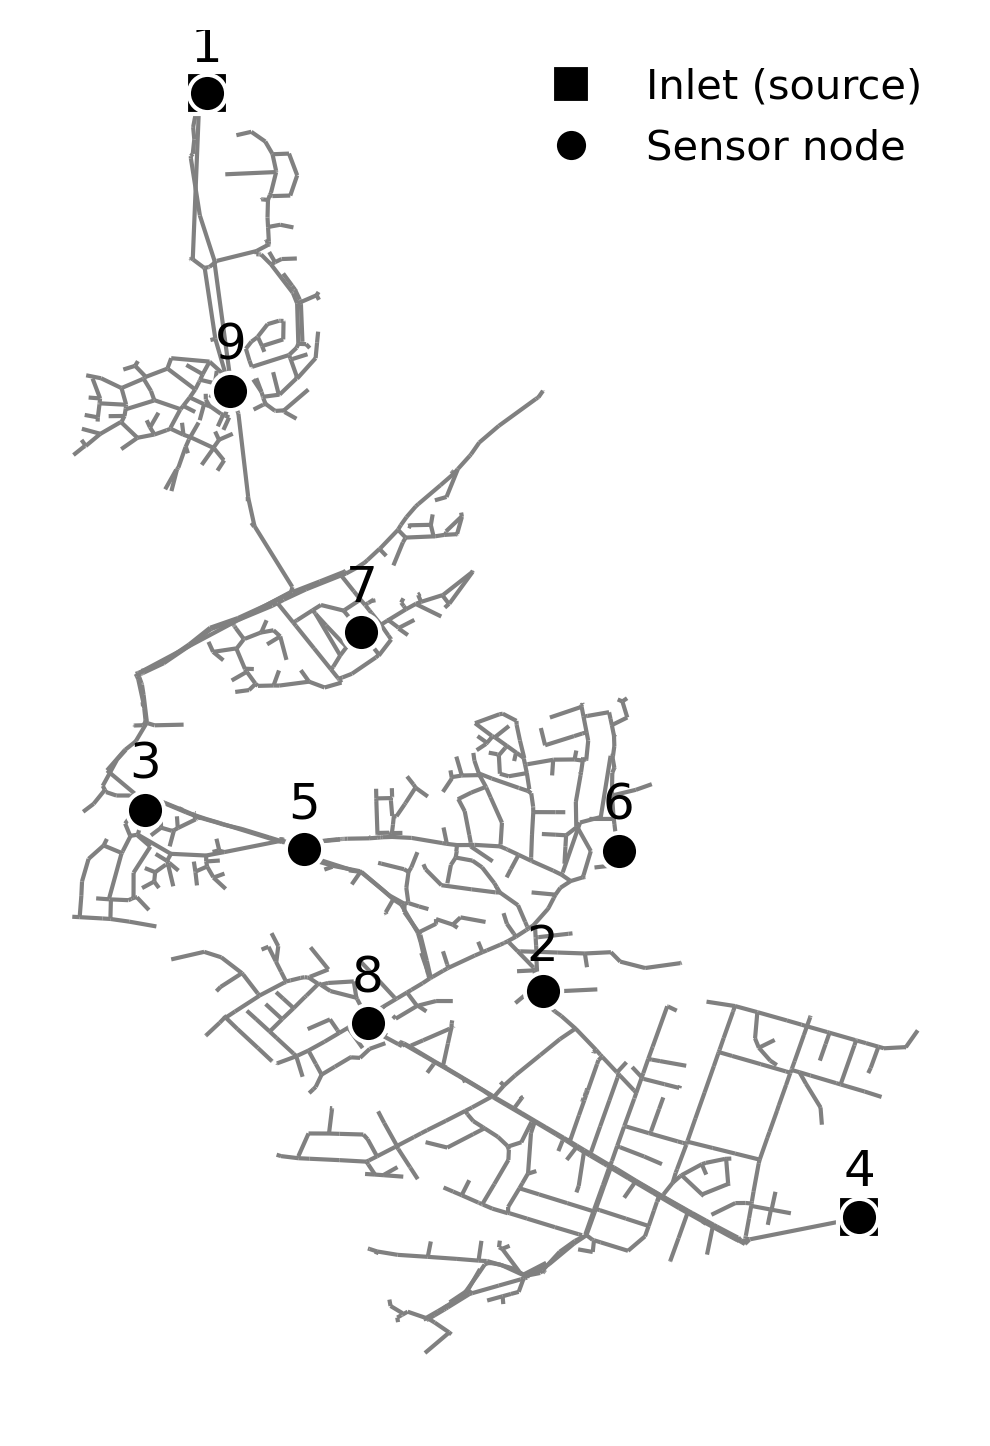

In [3]:
# sensor node data
sensor_names = ['node_2746', 'node_1811', 'node_2367', 'node_2747', 'node_1809', 'node_2673', 'node_2506', 'node_1773', 'node_1802'] # edit accordingly
# sensor_names = ['node_2746', 'node_1811', 'node_2367', 'node_2747', 'node_1809', 'node_2673', 'node_1773', 'node_1802'] # edit accordingly


# plot network layout
legend_labels = {'Inlet (source)': 'black', 'Sensor node': 'black'}
plt.figure(figsize=(4, 6))
plot_network(wdn, sensor_nodes=sensor_names, legend_labels=legend_labels, sensor_labels=True)

#### Control scenarios
In this study, we consider three (3) hydraulic control scenarios for investigating water quality dynamics. These control scenarios employ the following valve types: (i) pressure reducing valves (PRVs); (ii) dynamic boundary valves (DBVs); and automatic flushing valves (AFVs).

1. **No control.** This scenario considers a fixed topology with kept-shut boundary valves (BVs) separating the two DMAs. Furthermore, there is no pressure control at the network inlets. 

<Figure size 1200x1800 with 0 Axes>

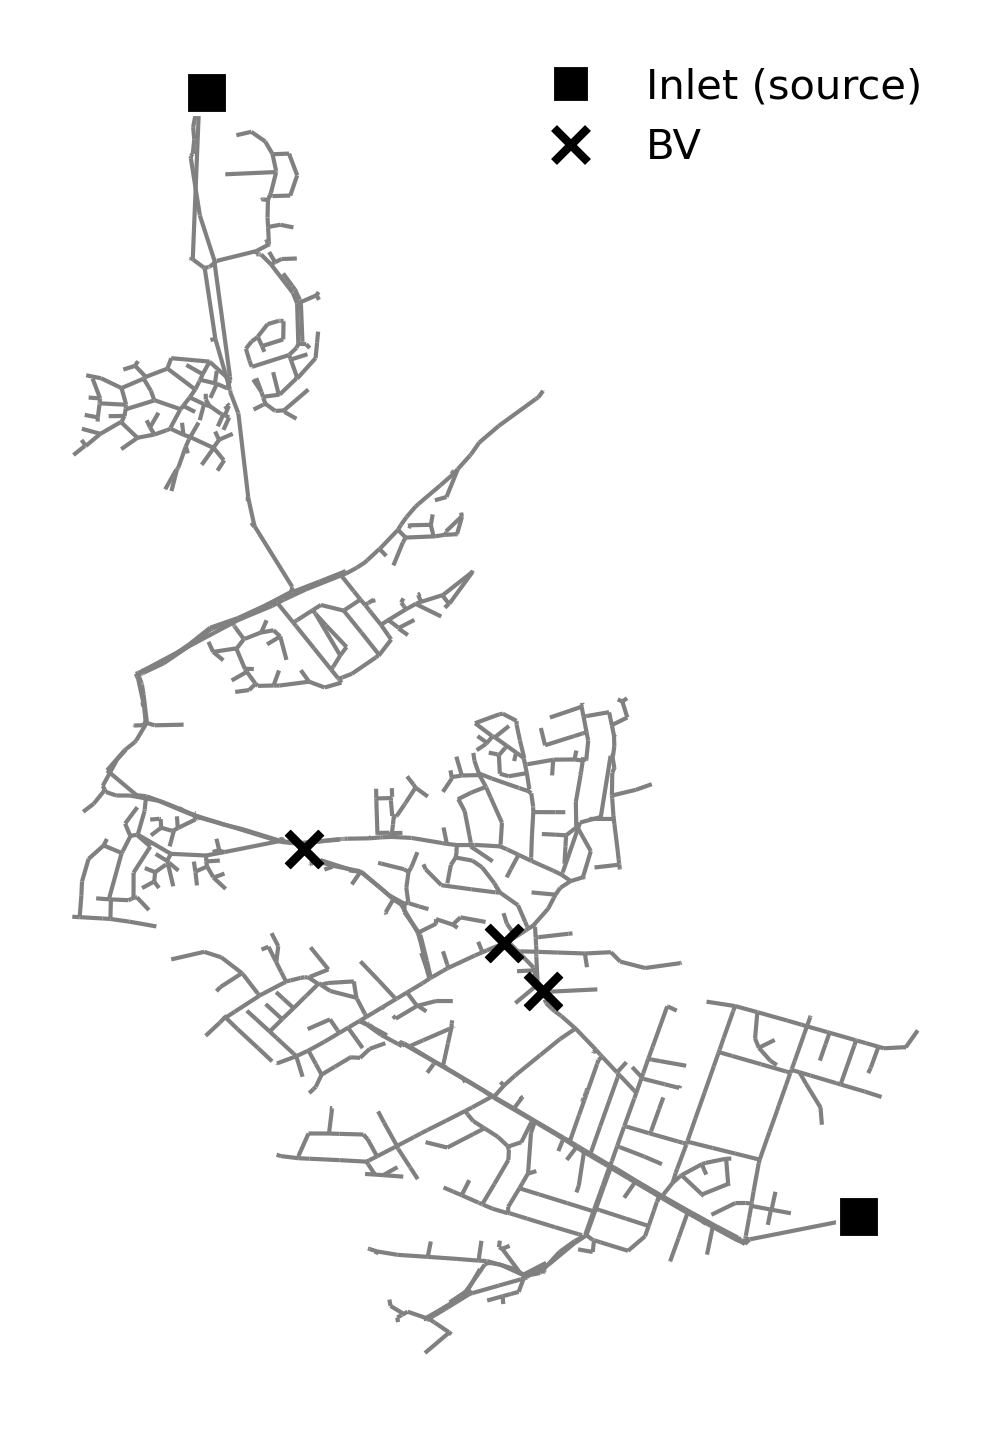

In [4]:
# no control valves
dbv = ['link_2747', 'link_2748']
bv_open = ['link_2336', 'link_2389', 'link_2508', 'link_2555']
bv_close = ['link_2431']
    
dbv_nodes = []
for link_id in dbv:
    dbv_nodes.extend(wdn.link_df.loc[wdn.link_df['link_ID'] == link_id, ['node_out', 'node_in']].values.flatten())
    
bv_close_nodes = []
for link_id in bv_close:
    bv_close_nodes.extend(wdn.link_df.loc[wdn.link_df['link_ID'] == link_id, ['node_out', 'node_in']].values.flatten())

# plot network layout
legend_labels = {'Inlet (source)': 'black', 'BV': 'black'}
plt.figure(figsize=(4, 6))
plot_network(wdn, bv_nodes=bv_close_nodes+dbv_nodes, legend_labels=legend_labels)

2. **Existing control.** This scenario represents the existing controls in BWFLnet, as operated by Bristol Water. PRVs are in the same locations as the no control scenario, but they now have dynamic set-points at each 15-minute control interval. Additionally, two of the kept-shut BVs are replaced with remote-controlled throttle control valves, referred to as dynamic boundary valves (DBVs). These are programmed to shut during the overnight period for leakage management purposes and open during the day to convey flow between DMAs. The following paper describes the BWFLnet control scenario in more detail.
    * Wright, R., Stoianov, I., Parpas, P., Henderson, K., and King, J. (2015). 'Adaptive water distribution networks with dynamically reconfigurable topology.' Journal of Hydroinformatics 16(6), 1280–1301, doi: 10.2166/hydro.2014.086.

<Figure size 1200x1800 with 0 Axes>

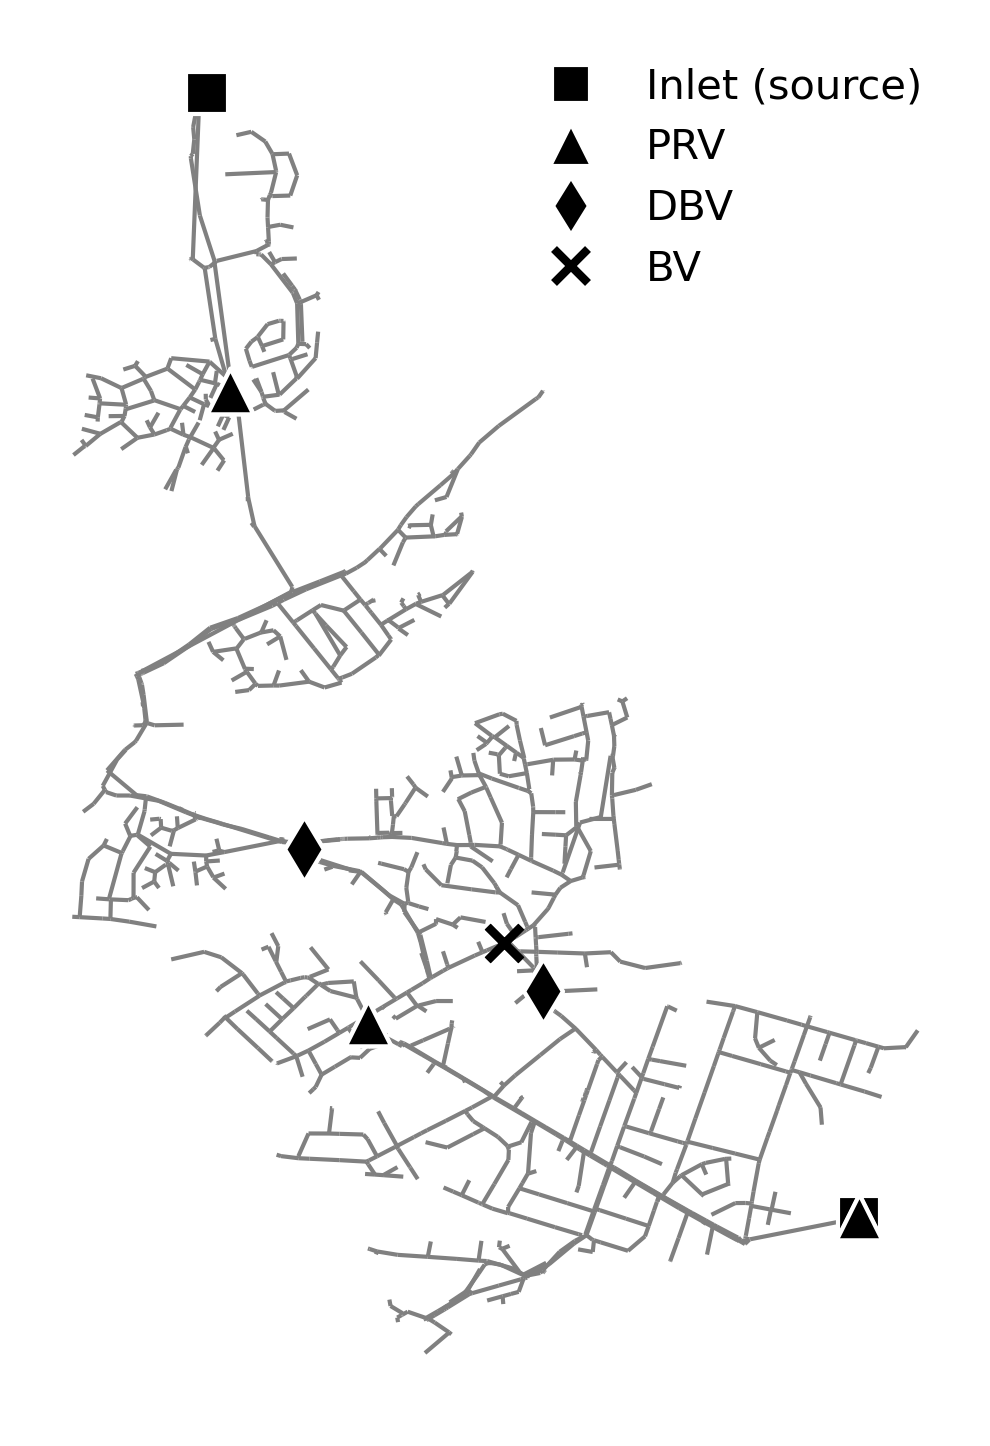

In [5]:
# existing control valves
prv = ['link_2756', 'link_2729', 'link_2743']
prv_dir = [1, 1, 1]
dbv = ['link_2747', 'link_2748']
bv_open = ['link_2336', 'link_2389', 'link_2508', 'link_2555']
bv_close = ['link_2431']

# find connecting nodes
prv_nodes = []
for link_id in prv:
    prv_nodes.extend(wdn.link_df.loc[wdn.link_df['link_ID'] == link_id, ['node_out', 'node_in']].values.flatten())
    
dbv_nodes = []
for link_id in dbv:
    dbv_nodes.extend(wdn.link_df.loc[wdn.link_df['link_ID'] == link_id, ['node_out', 'node_in']].values.flatten())
    
bv_close_nodes = []
for link_id in bv_close:
    bv_close_nodes.extend(wdn.link_df.loc[wdn.link_df['link_ID'] == link_id, ['node_out', 'node_in']].values.flatten())

# plot network layout
legend_labels = {'Inlet (source)': 'black', 'PRV': 'black', 'DBV': 'black', 'BV': 'black'}
plt.figure(figsize=(4, 6))
plot_network(wdn, prv_nodes=prv_nodes, dbv_nodes=dbv_nodes, bv_nodes=bv_close_nodes, legend_labels=legend_labels)

**Self-cleaning control.** This self-cleaning scenario considers a new design strategy for managing discolouration and pressure management objectives. The design comprises PRVs at new locations and with dynamic set-points at 15-minute intervals. Additionally, automatic flushing valves (AFVs) are installed with dynamic flushing rates at the same frequency. The locations of PRV and AFV locations were optimized using the methods proposed in the following paper:
   * Jenks, B., Ulusoy, A.-J., Pecci, F., and Stoianov, I. (2023). 'Dynamically adaptive networks for integrating optimal pressure management and self-cleaning controls.' Annual Reviews in Control 55, pp. 486–497, doi: 10.1016/j.arcontrol.2023.03.014       

<Figure size 1200x1800 with 0 Axes>

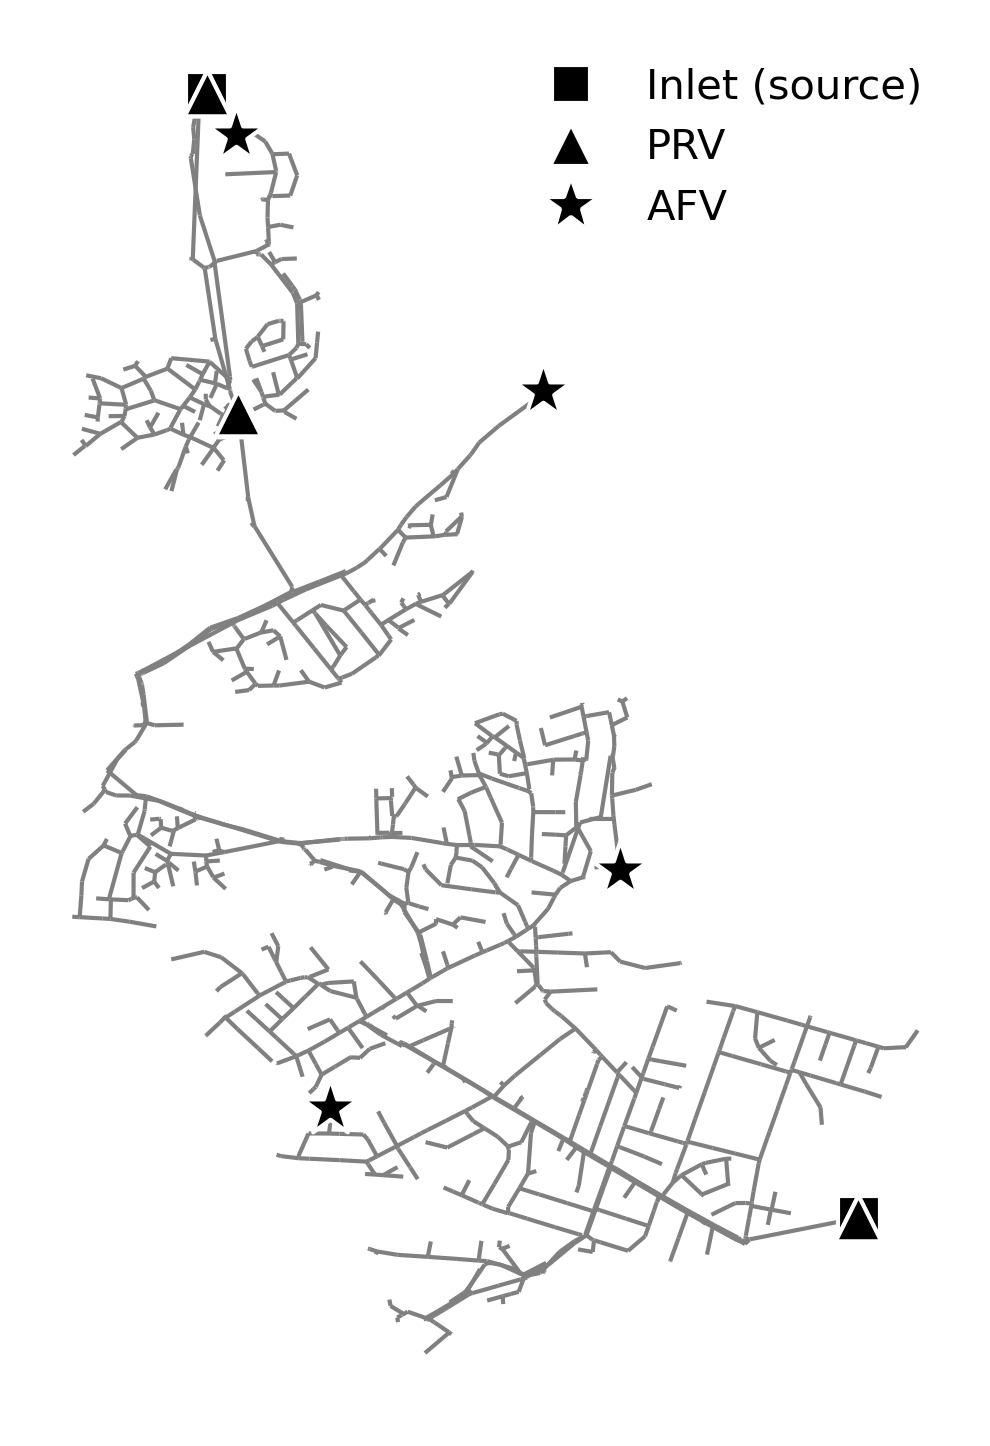

In [6]:
# self-cleaning control valves
prv_new = ['link_1963', 'link_0749', 'link_0615']
prv_new_dir = [-1, -1, 1]
bv_open = ['link_2336', 'link_2389', 'link_2508', 'link_2555']
bv_close = ['link_2431']
afv_nodes = ['node_1285', 'node_1236', 'node_2444', 'node_2095']

# find connecting nodes
prv_nodes = []
for link_id in prv_new:
    prv_nodes.extend(wdn.link_df.loc[wdn.link_df['link_ID'] == link_id, ['node_out', 'node_in']].values.flatten())

# plot network layout
legend_labels = {'Inlet (source)': 'black', 'PRV': 'black', 'AFV': 'black'}
plt.figure(figsize=(4, 6))
plot_network(wdn, prv_nodes=prv_nodes, afv_nodes=afv_nodes, legend_labels=legend_labels)

### Temporal connectivity metrics
Here, we compute temporal connectivity metrics corresponding to the selected control scenario.

In [7]:
scenario = 'existing control' # 'no control', existing control', 'self-cleaning control'

#### Hydraulic simulation
We first update hydraulic controls based on the selected control scenario.

In [8]:
sim_days_hyd = 1 # number of days in simulation

# call 'set_controls' function
if scenario == 'no control':
    wn = set_controls(net_name, data_path, scenario, bv_close=bv_close+dbv, bv_open=bv_open, sim_days=sim_days_hyd)
        
elif scenario == 'existing control':
    wn = set_controls(net_name, data_path, scenario, bv_close=bv_close, bv_open=bv_open, prv=prv, prv_dir=prv_dir, dbv=dbv, sim_days=sim_days_hyd)
    
elif scenario == 'self-cleaning control':
    wn = set_controls(net_name, data_path, scenario, bv_open=bv_open+bv_close, prv=prv_new, prv_dir=prv_new_dir, afv=afv_nodes, sim_days=sim_days_hyd)

The EPANET solver is then called via `wntr` to compute hydraulic states.

In [9]:
# 24-hour simulation period with 15-minute time steps
nt = 24
wn.options.time.duration = (nt * sim_days_hyd * 3600) - (0.25 * 3600)
wn.options.time.hydraulic_timestep = 60 * 15
wn.options.time.report_timestep = wn.options.time.hydraulic_timestep
wn.options.time.rule_timestep = wn.options.time.hydraulic_timestep
wn.convert_controls_to_rules(priority=3) 

# run hydraulic solver
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# obtain flow at links
df_flow = pd.DataFrame()
df_flow['timestamp'] = results.link['flowrate'].index.values / 3600
for col in results.link['flowrate'].columns:
    df_flow[col] = results.link['flowrate'][col].values * 1000
df_flow.set_index('timestamp', inplace=True)

# obtain pressure at nodes
df_pressure = pd.DataFrame()
df_pressure['timestamp'] = results.node['pressure'].index.values / 3600
for col in results.node['pressure'].columns:
    df_pressure[col] = results.node['pressure'][col].values
df_pressure.set_index('timestamp', inplace=True)

# obtain demand at nodes
df_demand = pd.DataFrame()
df_demand['timestamp'] = results.node['demand'].index.values / 3600
for col in results.node['demand'].columns:
    df_demand[col] = results.node['demand'][col].values * 1000
df_demand.set_index('timestamp', inplace=True)

Let's first plot key hydraulic states to ensure the controls are functioning properly.

Pressure heads at inlet/outlet of pressure control valves (e.g. PRVs and DBVs).

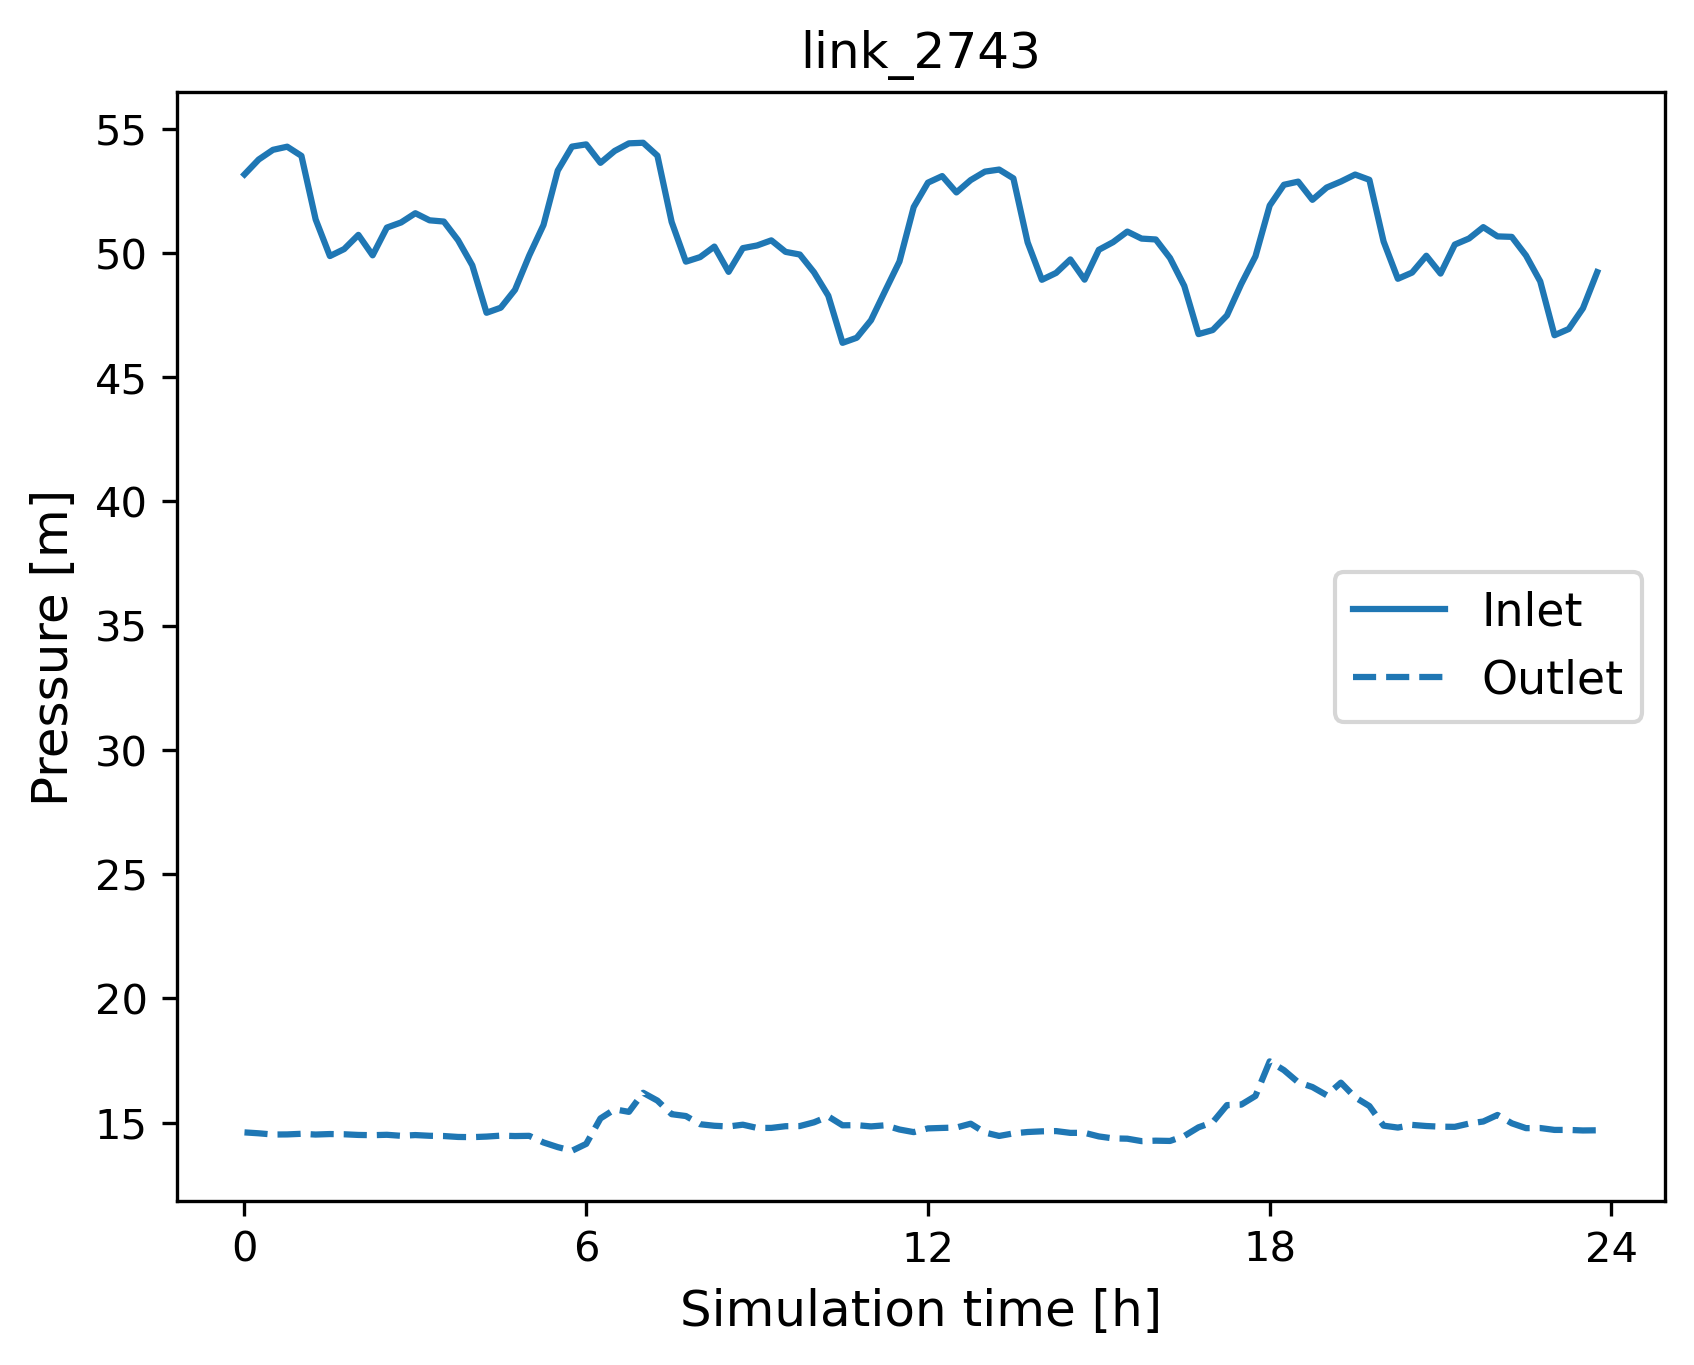

In [10]:
# plotting data
idx = 2
if scenario == 'existing control' or scenario == 'no control':
    link_to_plot = prv[idx]
    outlet = wdn.link_df.loc[wdn.link_df['link_ID'] == link_to_plot, ['node_in']].to_numpy()[0][0]
    inlet = wdn.link_df.loc[wdn.link_df['link_ID'] == link_to_plot, ['node_out']].to_numpy()[0][0]
elif scenario == 'self-cleaning control':
    link_to_plot = prv_new[idx]
    outlet = wdn.link_df.loc[wdn.link_df['link_ID'] == link_to_plot, ['node_in']].to_numpy()[0][0]
    inlet = wdn.link_df.loc[wdn.link_df['link_ID'] == link_to_plot, ['node_out']].to_numpy()[0][0]
        
# plotting code
plt.figure()
plt.plot(df_pressure.index, df_pressure[inlet], color='tab:blue', linestyle='-',
         label='Inlet')
plt.plot(df_pressure.index, df_pressure[outlet], color='tab:blue', linestyle='--',
         label='Outlet')
plt.xlabel('Simulation time [h]', fontsize=12)
plt.ylabel('Pressure [m]', fontsize=12)
plt.title(f'{link_to_plot}')
if sim_days_hyd <= 1:
    plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 6))
elif sim_days_hyd > 1 and sim_days_hyd < 5:
    plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 12))
else:
    plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 24))
plt.legend(fontsize=11)
plt.show()

Flow across boundary valves (e.g. DBVs and kept-shut BVs).

<Figure size 1920x1440 with 0 Axes>

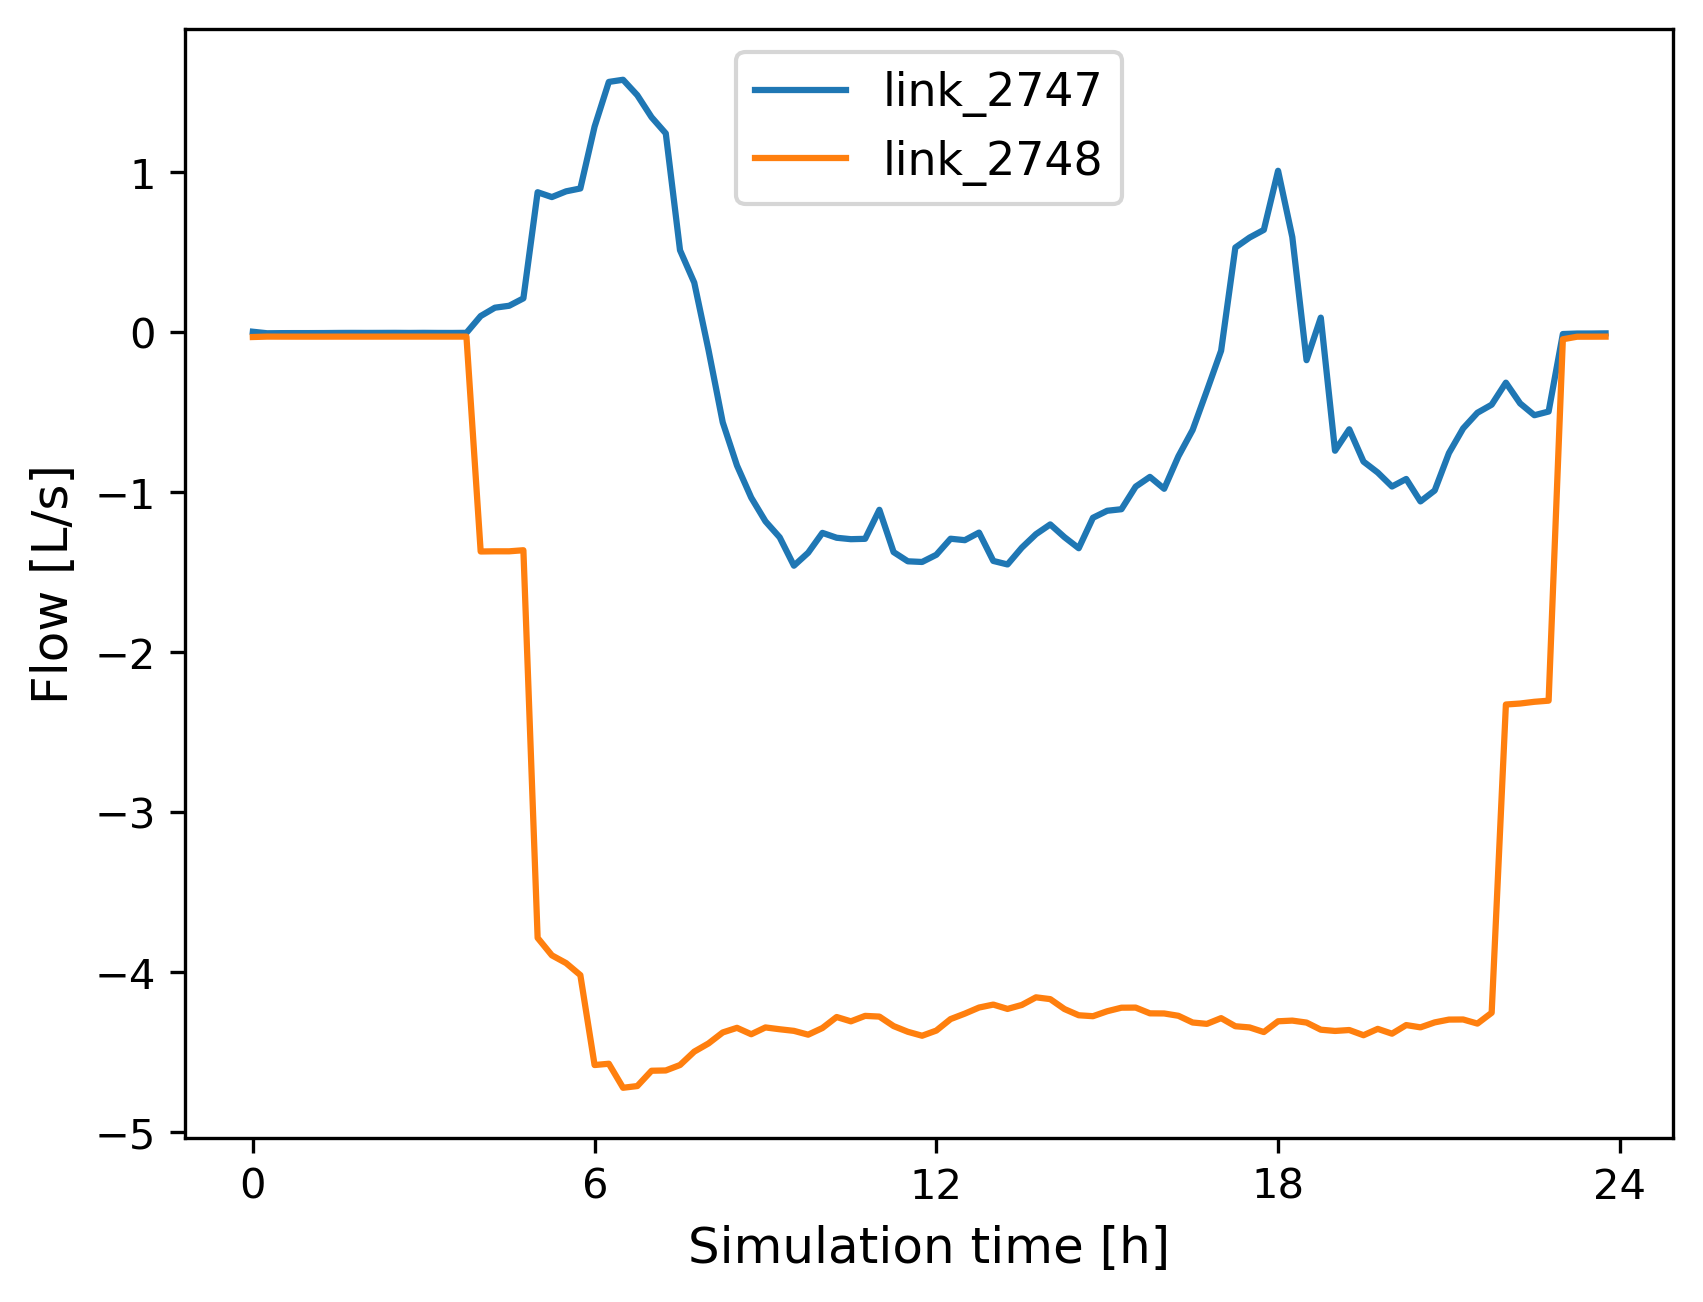

In [11]:
if scenario is not 'self-cleaning control':
    # input plotting data
    link_to_plot = dbv

    # plotting code
    plt.figure()
    df_flow[link_to_plot].plot(label=link_to_plot)
    plt.xlabel('Simulation time [h]', fontsize=12)
    plt.ylabel('Flow [L/s]', fontsize=12)
    if sim_days_hyd <= 1:
        plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 6))
    elif sim_days_hyd > 1 and sim_days_hyd < 5:
        plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 12))
    else:
        plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 24))
    plt.legend(fontsize=11)
    plt.show()
else:
    print(f'DBVs or kept-shut BVs not included in "{scenario}" scenario.')

Flushing demands at AFV nodes.

In [12]:
if scenario == 'self-cleaning control':
    # input plotting data
    node_to_plot = afv_nodes

    # plotting code
    plt.figure()
    df_demand[node_to_plot].plot(label=node_to_plot)
    plt.xlabel('Simulation time [h]', fontsize=12)
    plt.ylabel('Flushing demand [L/s]', fontsize=12)
    if sim_days_hyd <= 1:
        plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 6))
    elif sim_days_hyd > 1 and sim_days_hyd < 5:
        plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 12))
    else:
        plt.xticks(np.arange(0, nt * sim_days_hyd + 1, 24))
    plt.legend(fontsize=11)
    plt.show()
else:
    print(f'AFVs not included in "{scenario}" scenario.')

AFVs not included in "existing control" scenario.


#### Source trace simulation
Another temporal connectivity metric to consider is the contribution of source water at nodes across the network. This requires a water quality simulation.

The control settings are updated to extend over a number of simulation days. This is done to ensure water reaches all nodes and periodic behaviour in hydraulic conditions is observed.

In [13]:
sim_days_qual = 7 # number of days in simulation

# call 'set_controls' function
if scenario == 'no control':
    wn = set_controls(net_name, data_path, scenario, bv_close=bv_close+dbv, bv_open=bv_open, sim_days=sim_days_qual)
        
elif scenario == 'existing control':
    wn = set_controls(net_name, data_path, scenario, bv_close=bv_close, bv_open=bv_open, prv=prv, prv_dir=prv_dir, dbv=dbv, sim_days=sim_days_qual)
    
elif scenario == 'self-cleaning control':
    wn = set_controls(net_name, data_path, scenario, bv_open=bv_open+bv_close, prv=prv_new, prv_dir=prv_new_dir, afv=afv_nodes, sim_days=sim_days_qual)

The EPANET solver is called via `wntr` to compute water quality (source trace) states.

In [14]:
# 24-hour simulation period with 15-minute time steps
nt = 24
wn.options.time.duration = (nt * sim_days_qual * 3600) - (0.25 * 3600)
wn.options.time.hydraulic_timestep = 60 * 15
wn.options.time.quality_timestep = 60 * 5
wn.options.time.report_timestep = wn.options.time.hydraulic_timestep
wn.options.time.rule_timestep = wn.options.time.hydraulic_timestep
wn.convert_controls_to_rules(priority=3) 

# set trace parameters
wn.options.quality.parameter = 'TRACE'
sources = wdn.net_info['reservoir_names']
df_trace_0 = pd.DataFrame()
df_trace_1 = pd.DataFrame()

# run water quality solver
for idx, name in enumerate(sources):

    # set trace node
    wn.options.quality.trace_node = name
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()
    
    # obtain quality at nodes
    if idx == 0:
        df_trace_0['timestamp'] = results.node['quality'].index.values / 3600
        for col in results.node['quality'].columns:
            df_trace_0[col] = results.node['quality'][col].values
        df_trace_0.set_index('timestamp', inplace=True)
    elif idx == 1:
        df_trace_1['timestamp'] = results.node['quality'].index.values / 3600
        for col in results.node['quality'].columns:
            df_trace_1[col] = results.node['quality'][col].values
        df_trace_1.set_index('timestamp', inplace=True)

Since 'existing control' and 'self-cleaning control' scenarios allow flow transfer between the two DMAs, there are a number of nodes which may be supplied from both sources over the simulation period. In this work, we consider such conditions as increased **hydraulic dynamics** in the network. To highlight such areas, we take the maximum average source contribution over the simulation period, whereby nodes with lower values indicate more **hydraulic dynamics**. Note that the average source contribution is computed across the last day in the simulation to ensure periodic behaviour is observed.

In [15]:
# compute maximum average source trace over last 24 hours in simulation period
max_avg_trace = pd.concat([df_trace_0.tail(96).mean(), df_trace_1.tail(96).mean()], axis=1).max(axis=1)
df_trace = pd.DataFrame(max_avg_trace, columns=['source_trace']).T

We confirm that periodic behaviour in water quality (source trace) states is observed by plotting select nodes most distant from each source.

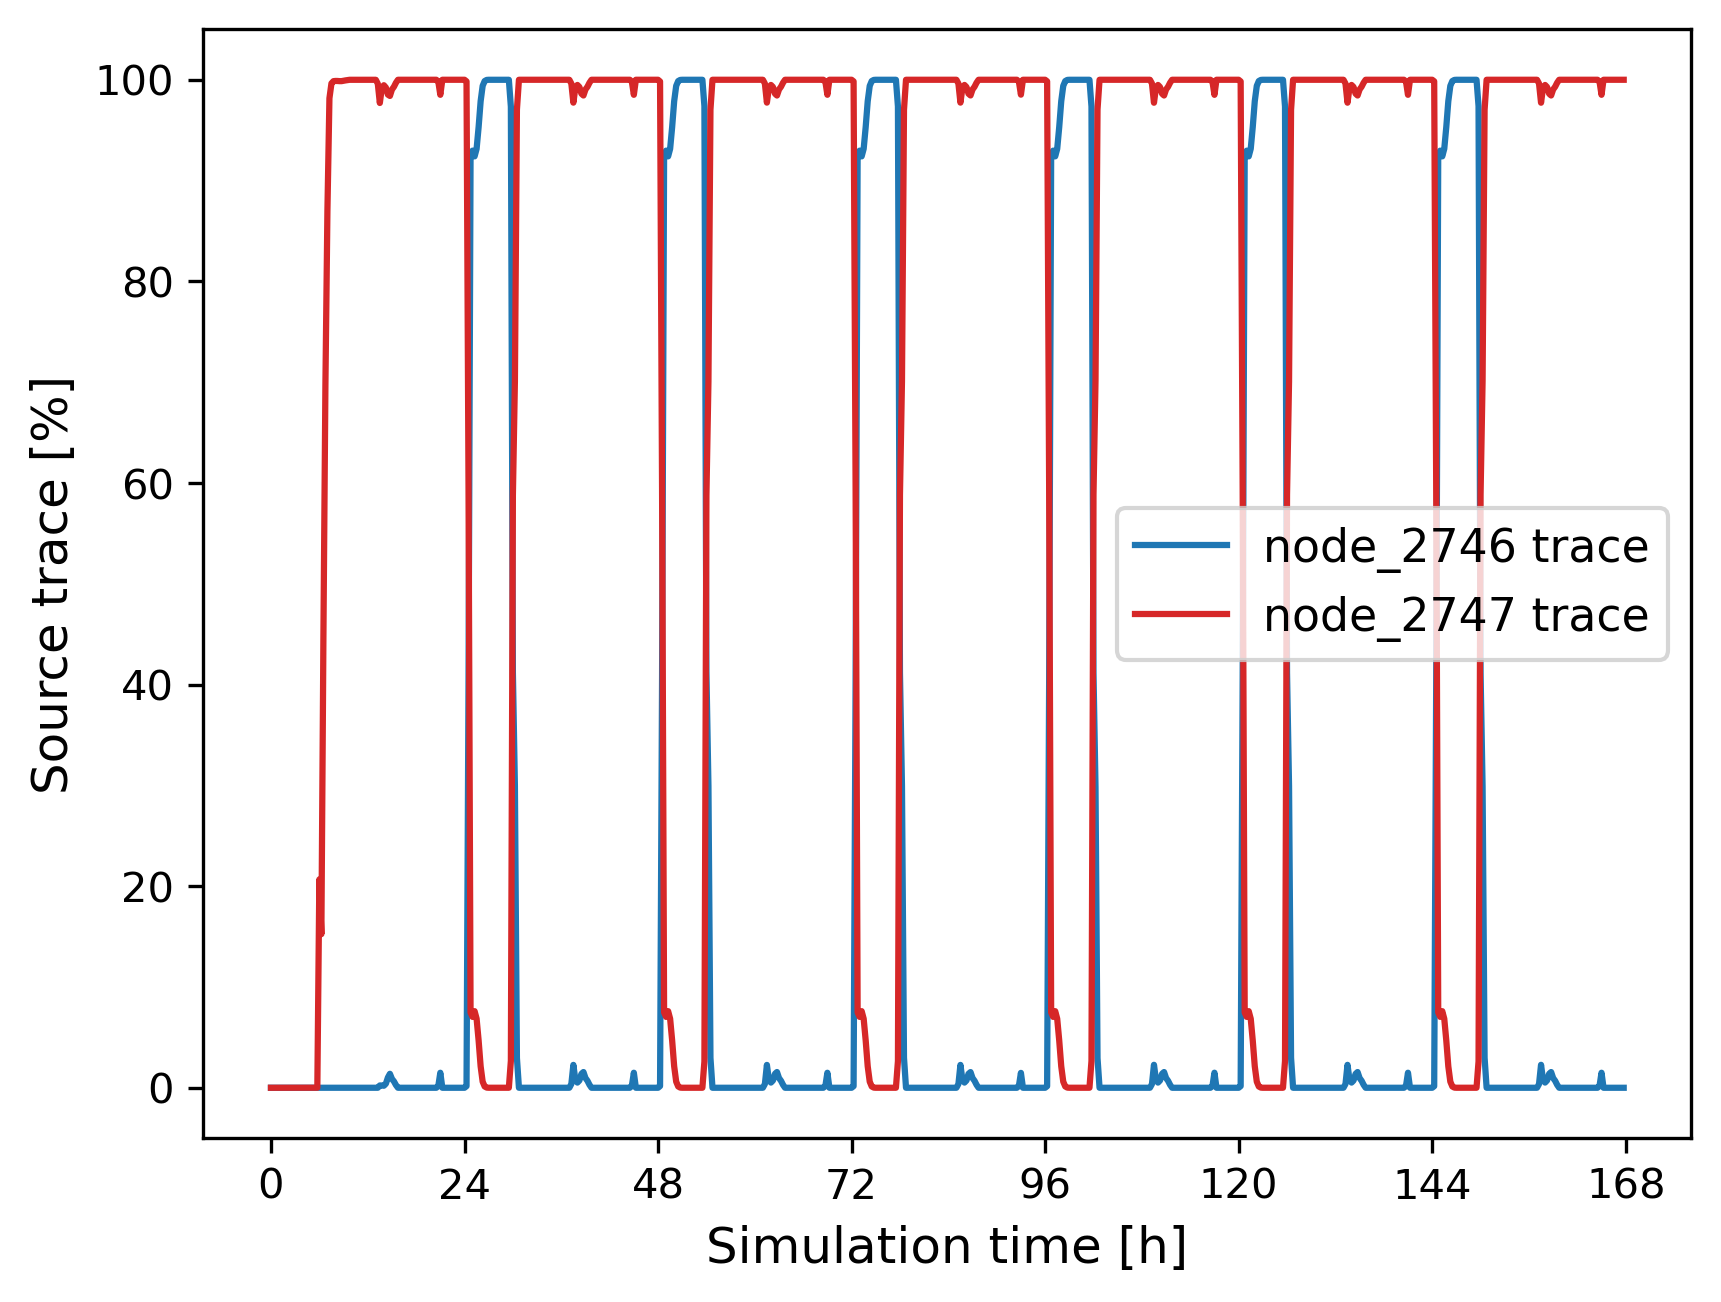

In [16]:
# input plotting data
# node_to_plot = 'node_1827' # north DMA node
# node_to_plot = 'node_0447' # south DMA node
# node_to_plot = 'node_0513' # node at DMA boundary
node_to_plot = 'node_1152' # node at DMA boundary

# plotting code
plt.figure()
df_trace_0[node_to_plot].plot(label=sources[0]+' trace', color='tab:blue')
df_trace_1[node_to_plot].plot(label=sources[1]+' trace', color='tab:red')
plt.xlabel('Simulation time [h]', fontsize=12)
plt.ylabel('Source trace [%]', fontsize=12)
if sim_days_qual <= 1:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 6))
elif sim_days_qual > 1 and sim_days_qual < 5:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 12))
else:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 24))
plt.legend(fontsize=11)
plt.show()

#### Temporal metric plots
We compute three (3) temporal connectivity metrics to investigate hydraulic dynamics resulting from the considered control scenarios:
* **Flow reversals**: the number of flow direction changes across a link during a 24-h simulation
* **Flow coefficient of variation (CV)**: the relative variability of link flow across a 24-h simulation
* **Mean source trace**: mean source trace percentage across the last 24-h period in a 7-day simulation

These temporal metrics are plotted below for the previously defined control scenario.

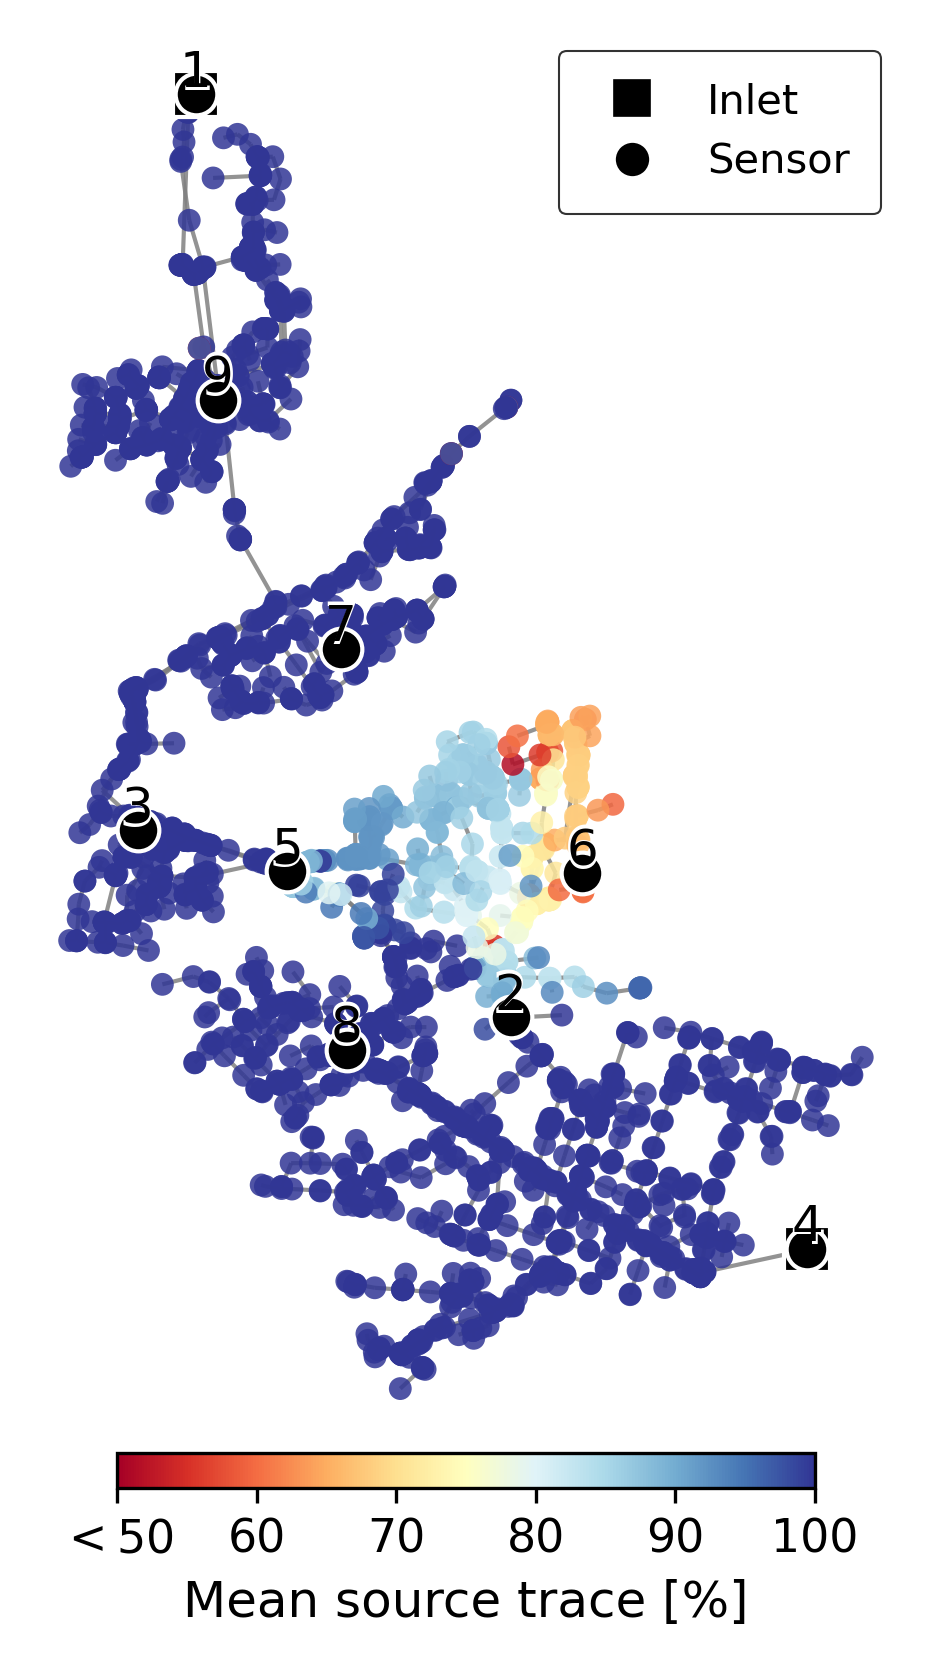

In [17]:
temporal_metric = 'source trace' # 'flow reversal', 'flow cv', 'source trace'
plot_temporal_metric(wdn, temporal_metric, df_flow, df_trace, sensor_names)

### Simulation of disinfectant residuals
Here, we simulate disinfectant residuals across BWFLnet for the selected control scenario.

In [18]:
scenario = 'existing control' # 'no control', existing control', 'self-cleaning control'

The control settings are again applied.

In [19]:
sim_days_qual = 7 # number of days in simulation

# call 'set_controls' function
if scenario == 'no control':
    wn = set_controls(net_name, data_path, scenario, bv_close=bv_close+dbv, bv_open=bv_open, sim_days=sim_days_qual)
        
elif scenario == 'existing control':
    wn = set_controls(net_name, data_path, scenario, bv_close=bv_close, bv_open=bv_open, prv=prv, prv_dir=prv_dir, dbv=dbv, sim_days=sim_days_qual)
    
elif scenario == 'self-cleaning control':
    wn = set_controls(net_name, data_path, scenario, bv_open=bv_open+bv_close, prv=prv_new, prv_dir=prv_new_dir, afv=afv_nodes, sim_days=sim_days_qual)

Water quality simulation parameters are setup in the following code. Note that we apply disinfectant source patterns using sensor data at DMA inlets. We also apply a constant bulk decay rate to both source locations. 

In [20]:
# 24-hour simulation period with 15-minute time steps
nt = 24
wn.options.time.duration = (nt * sim_days_qual * 3600) - (0.25 * 3600)
wn.options.time.hydraulic_timestep = 60 * 15
wn.options.time.quality_timestep = 60 * 5
wn.options.time.report_timestep = wn.options.time.hydraulic_timestep
wn.options.time.pattern_timestep = wn.options.time.hydraulic_timestep
wn.options.time.rule_timestep = wn.options.time.hydraulic_timestep
wn.convert_controls_to_rules(priority=3) 

# setup water quality parameters
wn.options.quality.parameter = "CHEMICAL"
wn.options.reaction.bulk_coeff = -2.5e-05 # units = 1/second
wn.options.reaction.wall_coeff = 0.0

# assign source patterns
source_0 = wdn.net_info['reservoir_names'][0]
source_1 = wdn.net_info['reservoir_names'][1]

# wq_data = pd.read_csv(os.path.join(data_path, 'wq_data.csv')).head(wdn.net_info['nt']*sim_days_qual)
# source_0_pat = wq_data[source_0].to_numpy()
# source_1_pat = wq_data[source_1].to_numpy()

source_0_pat = np.tile(np.random.normal(0.5, 0.05, wdn.net_info['nt']), sim_days_qual)
source_1_pat = np.tile(np.random.normal(0.8, 0.05, wdn.net_info['nt']), sim_days_qual)

wn.add_pattern("source_0_pat", source_0_pat)
wn.add_source("source_0", source_0, "CONCEN", 1, "source_0_pat")
wn.add_pattern("source_1_pat", source_1_pat)
wn.add_source("source_1", source_1, "CONCEN", 1, "source_1_pat")

# run water quality solver
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
df_qual = pd.DataFrame()

# obtain quality (disinfectant) results
df_qual['timestamp'] = results.node['quality'].index.values / 3600
for col in results.node['quality'].columns:
    df_qual[col] = results.node['quality'][col].values
df_qual.set_index('timestamp', inplace=True)

Plot disinfectant source patterns at DMA inlets.

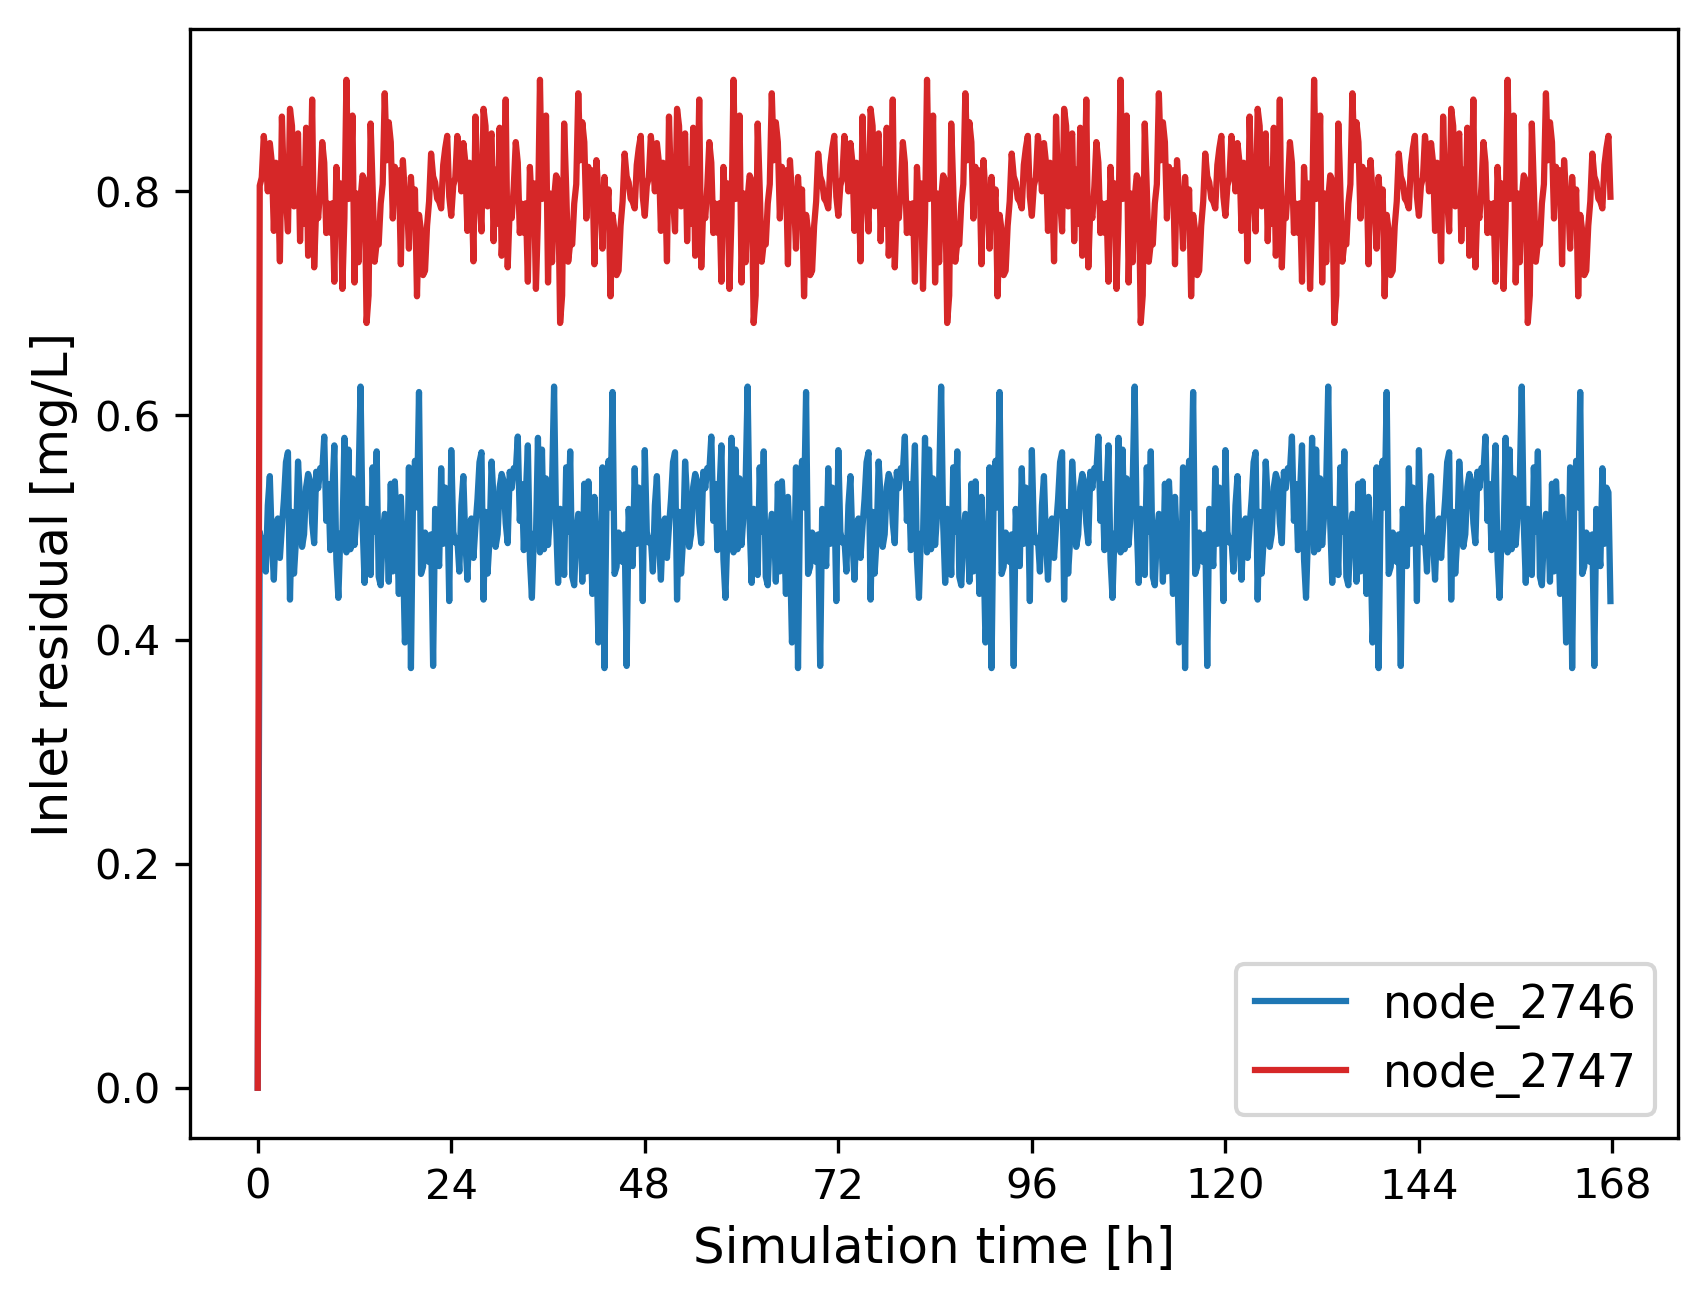

In [21]:
# plotting code
plt.figure()
df_qual[source_0].plot(label=sources[0], color='tab:blue')
df_qual[source_1].plot(label=sources[1], color='tab:red')
plt.xlabel('Simulation time [h]', fontsize=12)
plt.ylabel('Inlet residual [mg/L]', fontsize=12)
if sim_days_qual <= 1:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 6))
elif sim_days_qual > 1 and sim_days_qual < 5:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 12))
else:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 24))
plt.legend(fontsize=11)
plt.show()

Plot disinfectant residuals across the network at time step $t$.

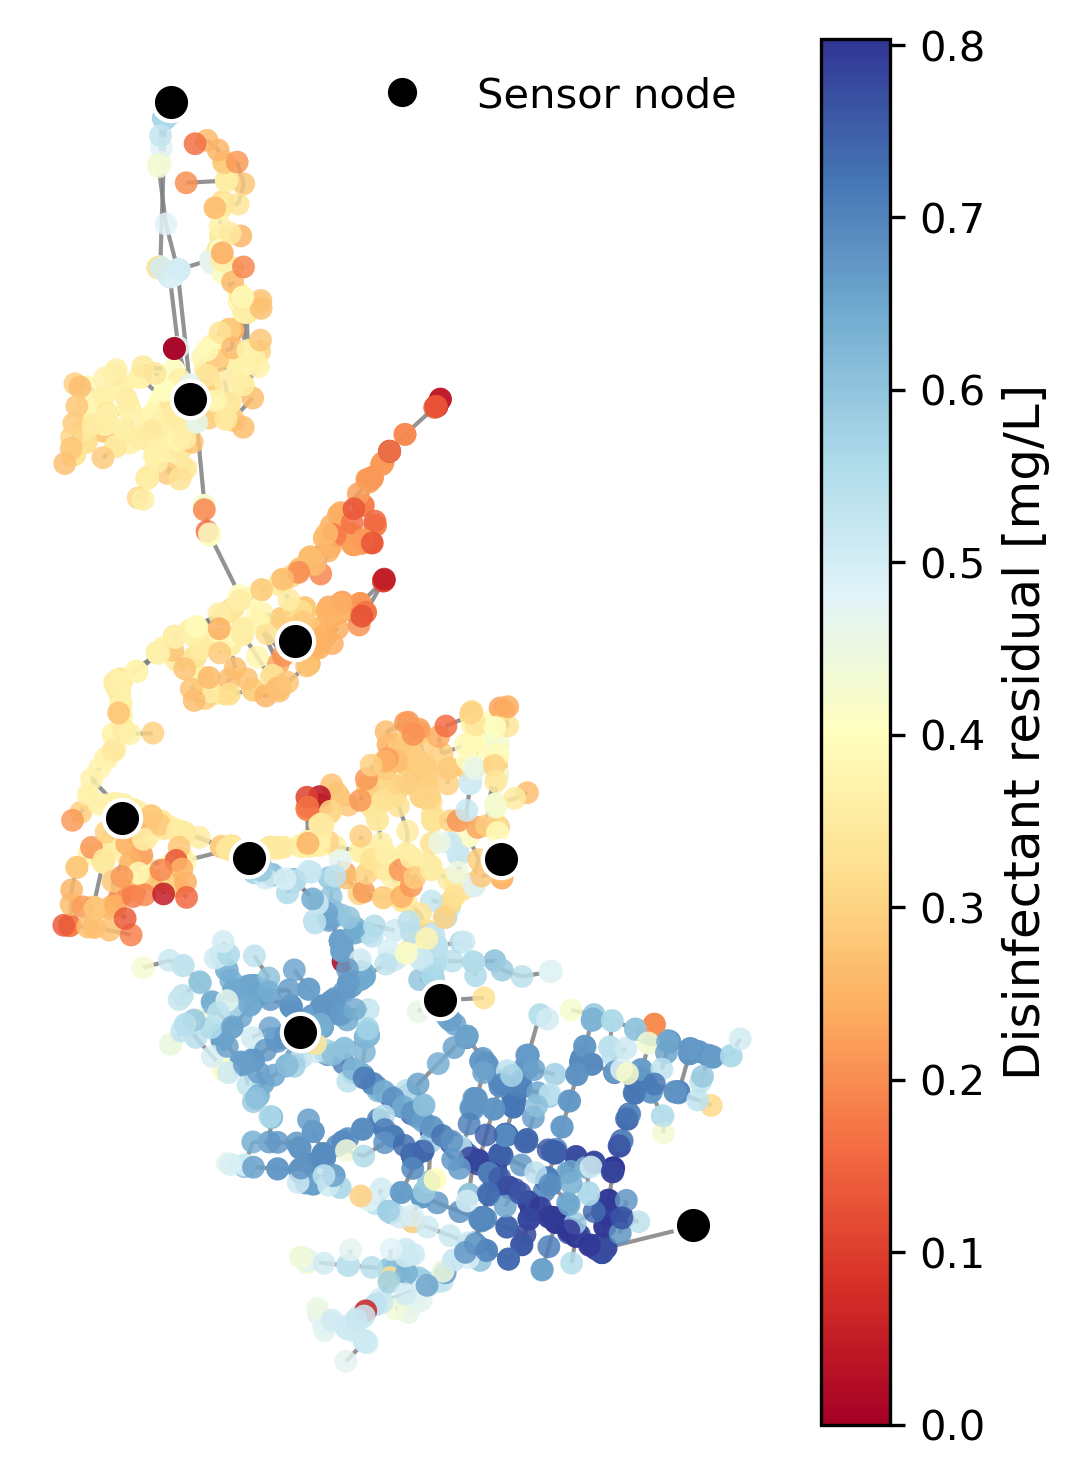

In [22]:
t = 384
legend_labels = {'Sensor node': 'black'}
plot_network(wdn, plot_type='disinfectant', sensor_nodes=sensor_names, vals_df=df_qual.T, t=t, legend_labels=legend_labels)

Plot disinfectant time series at select model nodes.

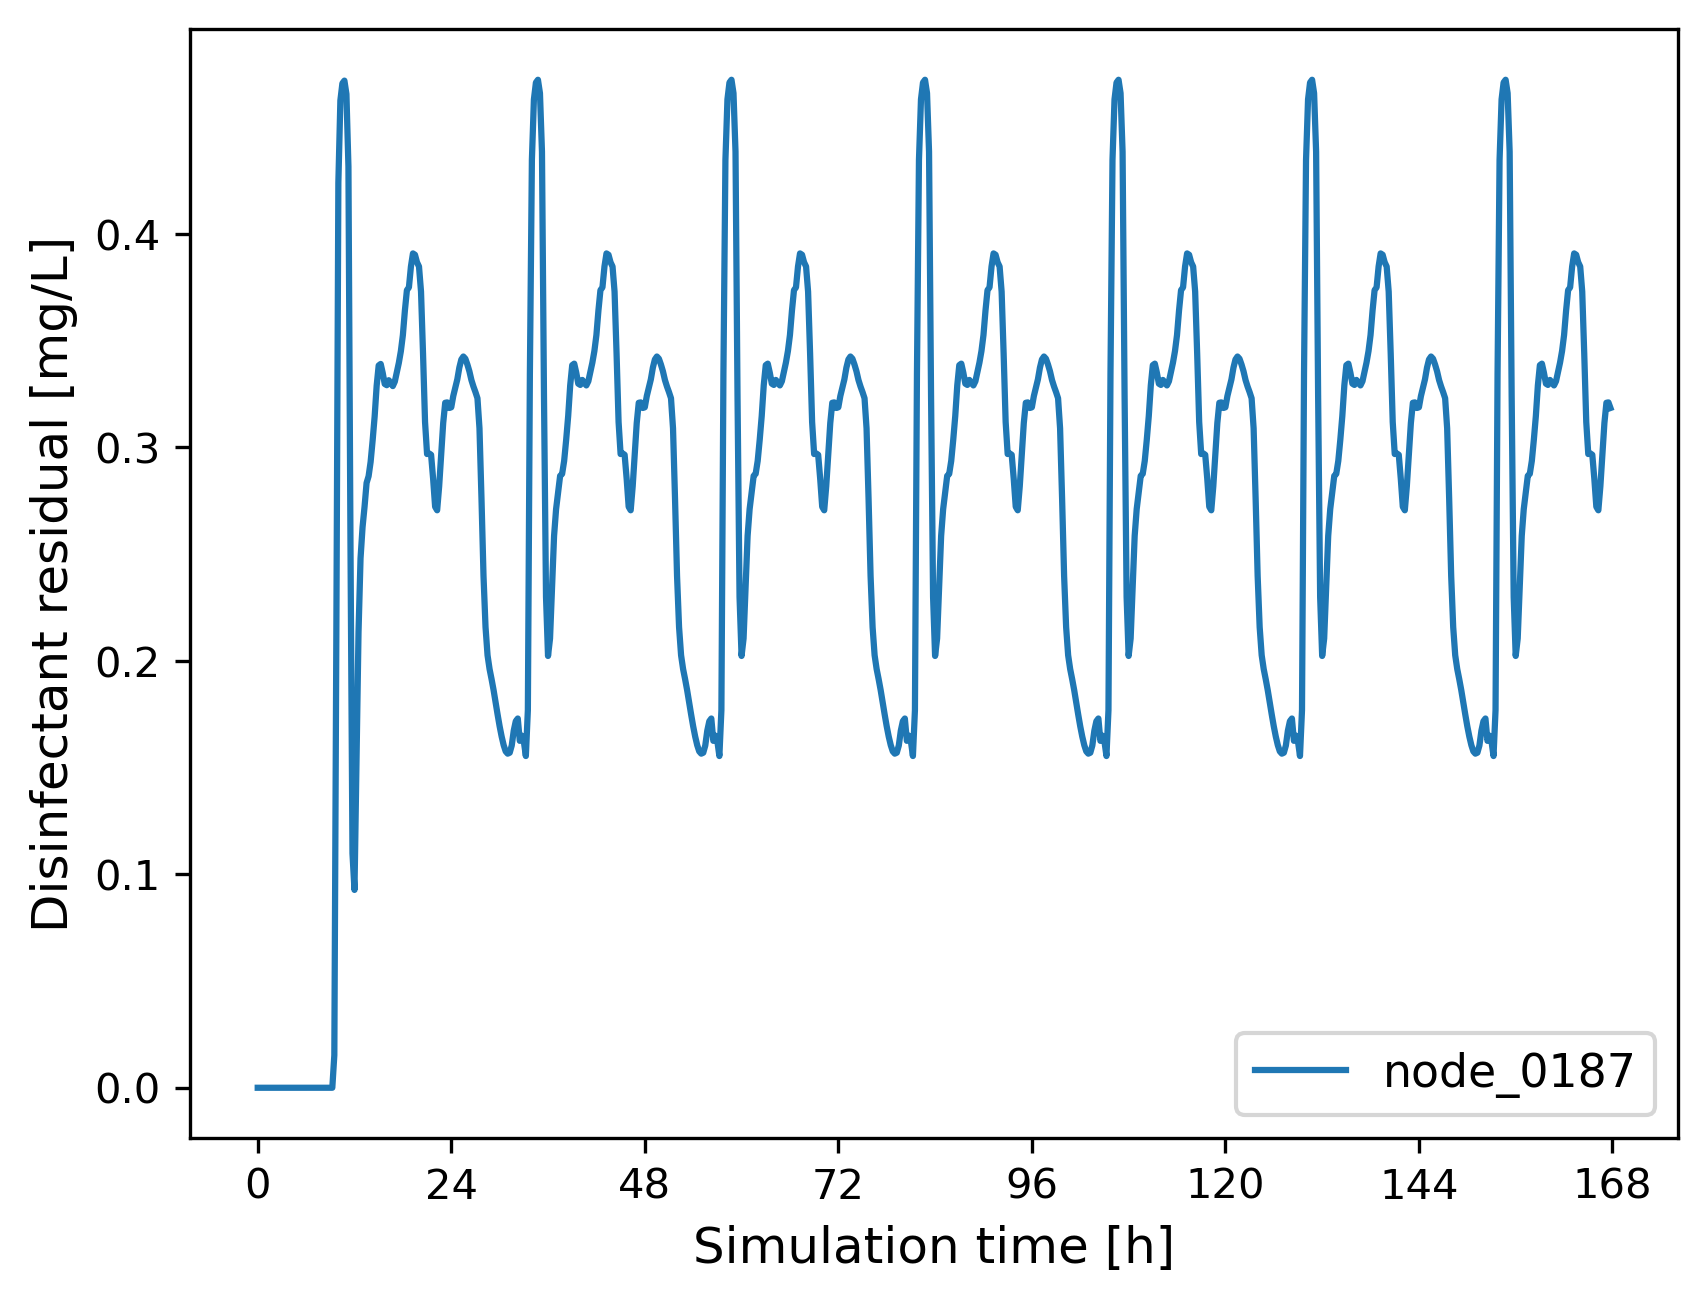

In [23]:
# plotting data
node_to_plot = 'node_0187' # existing control
# node_to_plot = 'node_1900' # existing control
# node_to_plot = 'node_0189' # existing control
# node_to_plot = 'node_1149' # existing control
# node_to_plot = 'node_2397' # self-cleaning control

# plotting code
plt.figure()
df_qual[node_to_plot].plot(label=node_to_plot, color='tab:blue')
plt.xlabel('Simulation time [h]', fontsize=12)
plt.ylabel('Disinfectant residual [mg/L]', fontsize=12)
if sim_days_qual <= 1:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 6))
elif sim_days_qual > 1 and sim_days_qual < 5:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 12))
else:
    plt.xticks(np.arange(0, nt * sim_days_qual + 1, 24))
plt.legend(fontsize=11)
plt.show()

We compute the **standard deviation** (SD) or **coefficient of variation** (CV) for disinfectants at each node across the last 3 days in the 7-day simulation. Similar to the temporal connectivity metrics, this aims to highlight nodes with greater disinfectant volatility for different control scenarios.

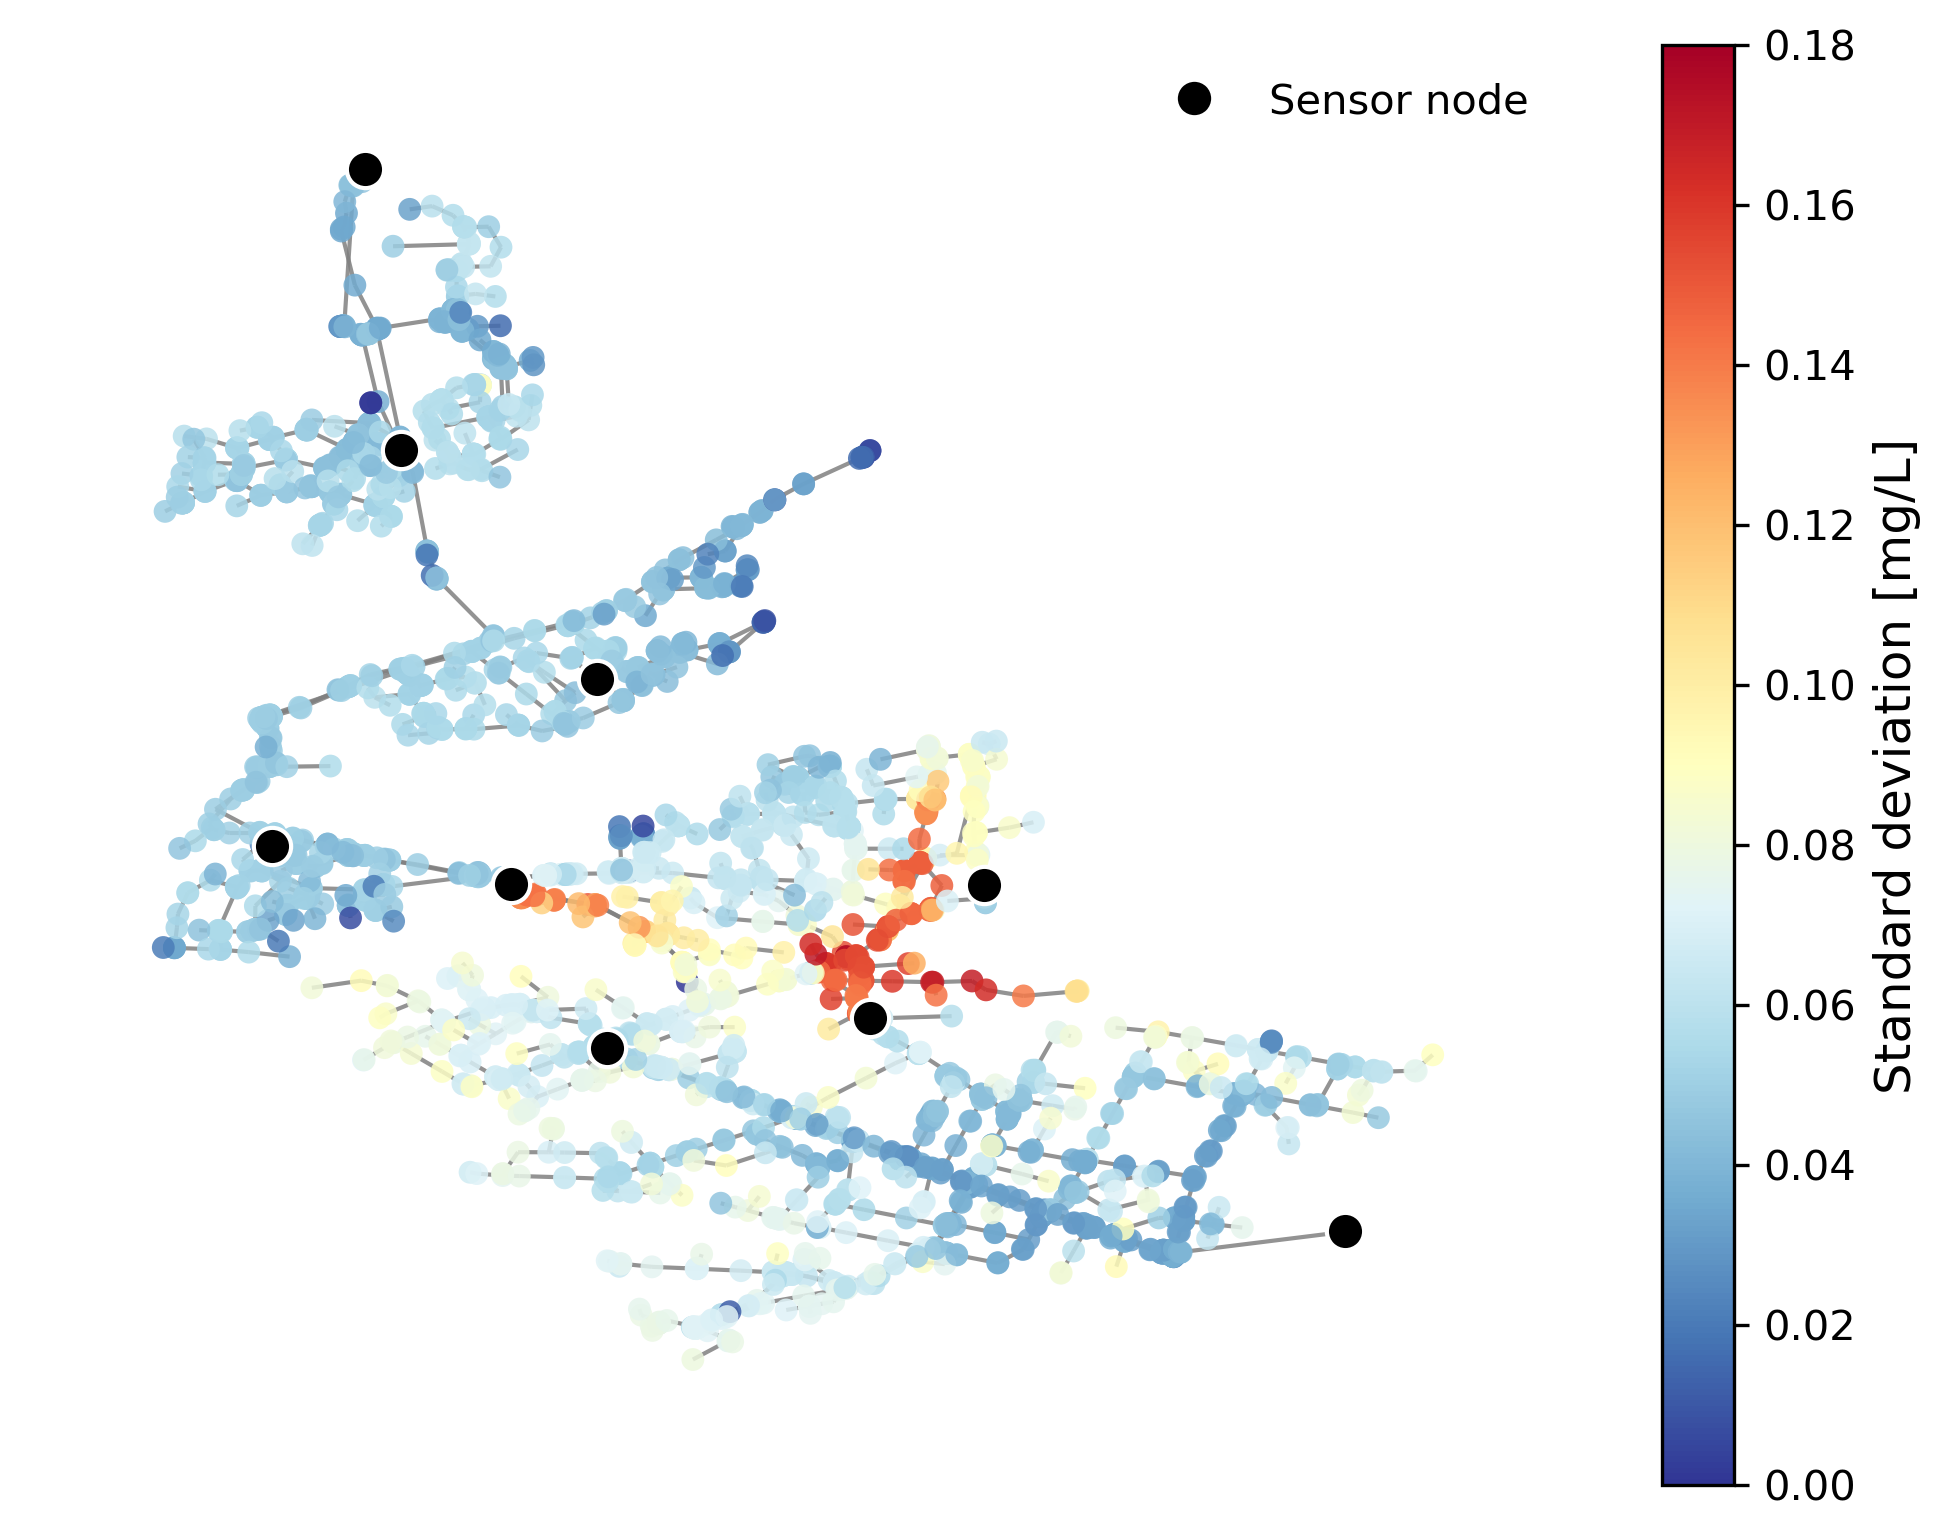

In [24]:
# metric = pd.DataFrame((df_qual.tail(wdn.net_info['nt']*(sim_days_qual-4)).std() / df_qual.tail(wdn.net_info['nt']*(sim_days_qual-4)).mean()).abs(), columns=['qual_cv'])
metric = pd.DataFrame(df_qual.tail(wdn.net_info['nt']*(sim_days_qual-4)).std(), columns=['qual_std'])

# node_weight_name = 'qual_cv'
node_weight_name = 'qual_std'

# cbar_title = 'Disinfectant CV'
cbar_title = 'Standard deviation [mg/L]'

# colorbar_ticks = (np.arange(0.05, 0.14, 0.02), [r"$<0.5$"] + [str(round(x,2)) for x in np.arange(0.07, 0.13, 0.02)] + [r"$\geq 0.13$"])
clims = (0, 0.18)
# colorbar_ticks = (np.arange(0, 0.41, 0.05), [str(round(x,2)) for x in np.arange(0, 0.36, 0.05)] + [r"$\geq 0.4$"])
# clims = (0, 0.4)

cmap = cm.get_cmap('RdYlBu').reversed()
# cmap = cm.get_cmap('Reds')
# cmap = cm.get_cmap('Blues')

# draw network and plot node weights
uG = nx.from_pandas_edgelist(wdn.link_df, source='node_out', target='node_in')
pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in wdn.node_df.iterrows()}

norm = plt.Normalize(vmin=clims[0], vmax=clims[1])
# norm = plt.Normalize(vmin=metric.min(), vmax=metric.max())
node_colors = cmap(norm(metric[node_weight_name]))
nx.draw(uG, pos, nodelist=metric.index, node_size=30, node_shape='o', alpha=0.85, linewidths=0, node_color=node_colors, cmap=cmap, edge_color='grey')
nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=80, node_shape='o', node_color='black', edgecolors='white') # draw sensor nodes

# create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(metric[node_weight_name])
colorbar = plt.colorbar(sm)
colorbar.set_label(cbar_title, fontsize=12)
# colorbar.set_ticks(colorbar_ticks[0])
# colorbar.set_ticklabels(colorbar_ticks[1], fontsize=11)

legend_labels = {'Sensor node': 'black'}
legend_handles = [plt.Line2D([0], [0], marker='o', markeredgewidth=2, markeredgecolor='white', color='white', markerfacecolor=color, markersize=10, label=label)  for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, loc='upper right', frameon=False)

### Temporal connectivity validation through sensor data statistics
We have 160 days (approx. 5.2 months) of continuous (15-minute) water quality data at the highlighted sensor nodes. This data corresponds to the existing control scenario. In this section, we aim to validate the increase in disinfectant variability at sensor nodes within the areas of the network with greater hydraulic dynamics. We show this by performing statistical analyses of sensor time series as well as the correlation between time series data of two sensor nodes.

#### Disinfectant variability of raw time series
The standard deviation is computed for each sensor node over the entire monitoring period.

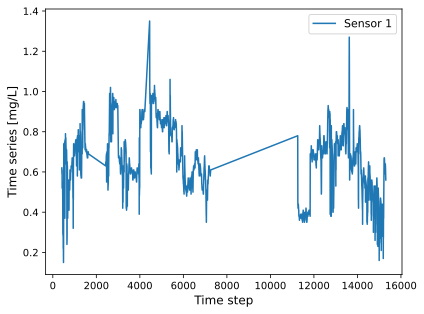

In [25]:
# load sensor data
wq_data = pd.read_csv(os.path.join(data_path, 'wq_data.csv'))
# wq_data = pd.read_csv(os.path.join(data_path, 'wq_data_2.csv'))

# interpolate rows with missing data
# wq_data.interpolate(method='spline', order=2, inplace=True)
# wq_data.fillna(value=wq_data.mean(), inplace=True)
wq_data.dropna(how='any', inplace=True)

# plot sensor data
sensor_names = ['node_2746', 'node_1811', 'node_2367', 'node_2747', 'node_1809', 'node_2673', 'node_2506', 'node_1773', 'node_1802'] # edit accordingly
# sensor_names = ['node_2746', 'node_1811', 'node_2367', 'node_2747', 'node_1809', 'node_2673', 'node_1773', 'node_1802'] # edit accordingly
sensor = 1

plt.figure()
wq_data[sensor_names[sensor-1]].plot(label=f'Sensor {sensor}', color='tab:blue')
plt.xlabel('Time step', fontsize=12)
plt.ylabel('Time series [mg/L]', fontsize=12)
plt.legend(fontsize=11)
plt.show()

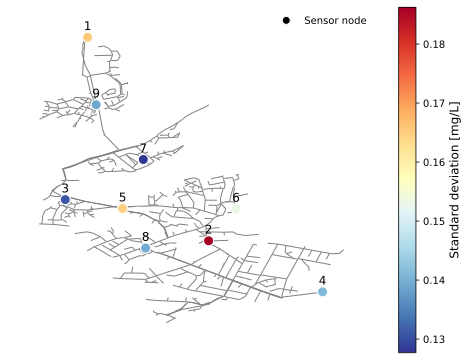

In [26]:
# compute standard deviation (SD)
sd = pd.DataFrame(wq_data.std(), columns=['sd'])

# compute coefficient of variation (CV)
cv = pd.DataFrame((wq_data.std() / wq_data.mean()), columns=['cv'])

# merge dataframes
wq_metrics = sd.merge(cv, left_index=True, right_index=True)

# plot variability metric spatially on sensor node map
legend_labels = {'Sensor node': 'black'}
plot_sensor_data(wdn, sensor_names, wq_metrics[['sd']], legend_labels=legend_labels, sensor_labels=True)

#### Disinfectant variability of differenced (stationary) time series
Remove trend by differencing the time series. This is a common approach for making time series data stationary.

First, we demonstrate the differencing process on time series data of a selected sensor.

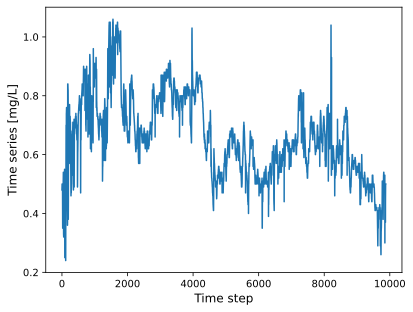

ADF statistic: -4.120268834972436
p-value: 0.0008964480239686835
Critical values:
1%: -3.4310140614194053
5%: -2.8618334751533405
10%: -2.566926211693164


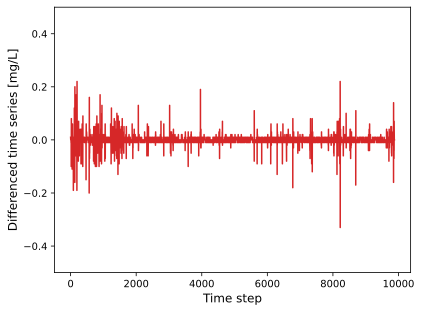

ADF Statistic: -24.85513614245938
p-value: 0.0
usedlag: 26
Mean: 2.024906348081403e-06 mg/L
Standard deviation (SD): 0.015340619663943655 mg/L
Root mean squared error (RMSE): 0.015340619797583815 mg/L
Mean absolute error (MAE): 0.005572542269920017 mg/L
95th percentile of absolute error: 0.020000000000000018 mg/L


In [27]:
# select sensor time series data (make for loop later)
idx = 8
sensor_data = wq_data[sensor_names[idx-1]].to_numpy()

# check if data is stationary (i.e. it is without trend)
plt.plot(np.arange(0, len(sensor_data)), sensor_data, color='tab:blue')
plt.xlabel('Time step', fontsize=12)
plt.ylabel('Time series [mg/L]', fontsize=12)
plt.show()

result = adfuller(sensor_data)
print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical values:')
for key, value in result[4].items():
 print(f'{key}: {value}')

# differenced time series
# n = 4
sensor_data_diff = np.diff(sensor_data, n=1)
# sensor_data_diff = sensor_data[n:] - sensor_data[:-n]

plt.plot(np.arange(0, len(sensor_data_diff)), sensor_data_diff, color='tab:red')
plt.xlabel('Time step', fontsize=12)
plt.ylabel('Differenced time series [mg/L]', fontsize=12)
plt.ylim(-0.5, 0.5)
plt.show()

result = adfuller(sensor_data_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'usedlag: {result[2]}')

# compute mean of differenced time series data
mean = np.mean(sensor_data_diff)
print(f'Mean: {mean} mg/L')

# compute SD of differenced time series data
sd = np.std(sensor_data_diff)
print(f'Standard deviation (SD): {sd} mg/L')

# compute mse of differenced time series data
rmse = np.sqrt(np.mean(sensor_data_diff ** 2))
print(f'Root mean squared error (RMSE): {rmse} mg/L')

# compute mae of differenced time series data
mae = np.mean(np.abs(sensor_data_diff))
print(f'Mean absolute error (MAE): {mae} mg/L')

# compute 95th percentile of differenced absolute error 
perc_95 = np.percentile(np.abs(sensor_data_diff), 95)
print(f'95th percentile of absolute error: {perc_95} mg/L')

Here, we compute the root mean squared error (RMSE) and mean absolute error (MAE) values for each differenced time series data. These values are included in the previously defined `wq_metrics` dataframe.

In [28]:
wq_metrics[['rmse', 'mae']] = None

for idx, name in enumerate(sensor_names):
    
    # get time series
    sensor_data = wq_data[name].to_numpy()
    
    # compute differenced time series
    sensor_data_diff = np.diff(sensor_data, n=1)
    
    # compute rmse of differenced time series
    rmse = np.sqrt(np.mean(sensor_data_diff ** 2))
    wq_metrics['rmse'][name] = rmse
    
    # compute mae of differenced time series
    mae = np.mean(np.abs(sensor_data_diff))
    wq_metrics['mae'][name] = mae

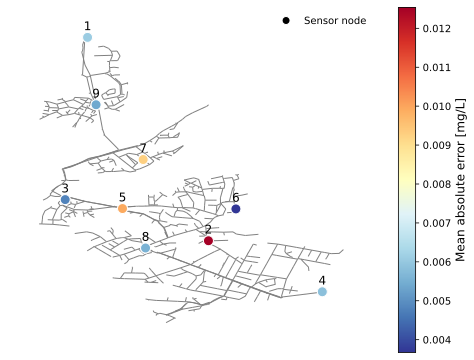

In [29]:
# plot variability metric spatially on sensor node map
legend_labels = {'Sensor node': 'black'}
plot_sensor_data(wdn, sensor_names, wq_metrics[['mae']], legend_labels=legend_labels, sensor_labels=True)

#### Granger causality
In addition to each individual sensor's time series, we also investigate the connectivity between two sensors through the Granger causality test.

First, we demonstrate the granger causality test results for a selected pair of sensors.

In [30]:
# select sensor indices
idx1 = 2
idx2 = 5

# define sensor data
sensor1_data = wq_data[sensor_names[idx1-1]].to_numpy()
sensor2_data = wq_data[sensor_names[idx2-1]].to_numpy()

# difference sensor data to ensure stationarity
sensor1_diff = np.diff(sensor1_data, n=1).reshape(-1, 1)
sensor2_diff = np.diff(sensor2_data, n=1).reshape(-1, 1)

# define max lag
n_lag = 96

# run granger causality test
data = np.hstack((sensor2_diff, sensor1_diff))
results = grangercausalitytests(data, n_lag, verbose=None)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=43.1741 , p=0.0000  , df_denom=9873, df_num=1
ssr based chi2 test:   chi2=43.1872 , p=0.0000  , df=1
likelihood ratio test: chi2=43.0930 , p=0.0000  , df=1
parameter F test:         F=43.1741 , p=0.0000  , df_denom=9873, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=159.0257, p=0.0000  , df_denom=9870, df_num=2
ssr based chi2 test:   chi2=318.2126, p=0.0000  , df=2
likelihood ratio test: chi2=313.1931, p=0.0000  , df=2
parameter F test:         F=159.0257, p=0.0000  , df_denom=9870, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=164.0744, p=0.0000  , df_denom=9867, df_num=3
ssr based chi2 test:   chi2=492.5724, p=0.0000  , df=3
likelihood ratio test: chi2=480.6801, p=0.0000  , df=3
parameter F test:         F=164.0744, p=0.0000  , df_denom=9867, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=128.8850, p=0.

ssr based F test:         F=19.9054 , p=0.0000  , df_denom=9783, df_num=31
ssr based chi2 test:   chi2=621.0414, p=0.0000  , df=31
likelihood ratio test: chi2=602.2417, p=0.0000  , df=31
parameter F test:         F=19.9054 , p=0.0000  , df_denom=9783, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=19.2268 , p=0.0000  , df_denom=9780, df_num=32
ssr based chi2 test:   chi2=619.3456, p=0.0000  , df=32
likelihood ratio test: chi2=600.6446, p=0.0000  , df=32
parameter F test:         F=19.2268 , p=0.0000  , df_denom=9780, df_num=32

Granger Causality
number of lags (no zero) 33
ssr based F test:         F=18.7907 , p=0.0000  , df_denom=9777, df_num=33
ssr based chi2 test:   chi2=624.3411, p=0.0000  , df=33
likelihood ratio test: chi2=605.3414, p=0.0000  , df=33
parameter F test:         F=18.7907 , p=0.0000  , df_denom=9777, df_num=33

Granger Causality
number of lags (no zero) 34
ssr based F test:         F=18.3907 , p=0.0000  , df_denom=9774, df_num=3

parameter F test:         F=12.0847 , p=0.0000  , df_denom=9699, df_num=59

Granger Causality
number of lags (no zero) 60
ssr based F test:         F=12.1030 , p=0.0000  , df_denom=9696, df_num=60
ssr based chi2 test:   chi2=735.2447, p=0.0000  , df=60
likelihood ratio test: chi2=709.0135, p=0.0000  , df=60
parameter F test:         F=12.1030 , p=0.0000  , df_denom=9696, df_num=60

Granger Causality
number of lags (no zero) 61
ssr based F test:         F=11.9276 , p=0.0000  , df_denom=9693, df_num=61
ssr based chi2 test:   chi2=736.8169, p=0.0000  , df=61
likelihood ratio test: chi2=710.4734, p=0.0000  , df=61
parameter F test:         F=11.9276 , p=0.0000  , df_denom=9693, df_num=61

Granger Causality
number of lags (no zero) 62
ssr based F test:         F=11.8154 , p=0.0000  , df_denom=9690, df_num=62
ssr based chi2 test:   chi2=742.0071, p=0.0000  , df=62
likelihood ratio test: chi2=715.2975, p=0.0000  , df=62
parameter F test:         F=11.8154 , p=0.0000  , df_denom=9690, df_num=6

ssr based F test:         F=10.4313 , p=0.0000  , df_denom=9615, df_num=87
ssr based chi2 test:   chi2=924.0442, p=0.0000  , df=87
likelihood ratio test: chi2=882.9989, p=0.0000  , df=87
parameter F test:         F=10.4313 , p=0.0000  , df_denom=9615, df_num=87

Granger Causality
number of lags (no zero) 88
ssr based F test:         F=10.4055 , p=0.0000  , df_denom=9612, df_num=88
ssr based chi2 test:   chi2=932.5425, p=0.0000  , df=88
likelihood ratio test: chi2=890.7572, p=0.0000  , df=88
parameter F test:         F=10.4055 , p=0.0000  , df_denom=9612, df_num=88

Granger Causality
number of lags (no zero) 89
ssr based F test:         F=10.3150 , p=0.0000  , df_denom=9609, df_num=89
ssr based chi2 test:   chi2=935.1375, p=0.0000  , df=89
likelihood ratio test: chi2=893.1222, p=0.0000  , df=89
parameter F test:         F=10.3150 , p=0.0000  , df_denom=9609, df_num=89

Granger Causality
number of lags (no zero) 90
ssr based F test:         F=10.3780 , p=0.0000  , df_denom=9606, df_num=9

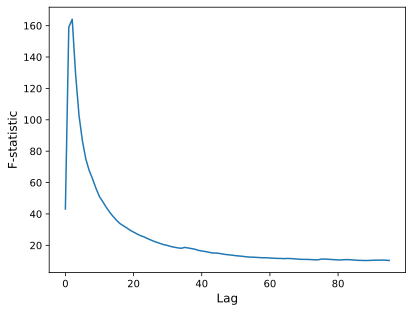

In [31]:
# extract F-statistics for each lag
f_statistics = []
for lag in range(1, n_lag + 1):
    f_statistic = results[lag][0]['ssr_ftest'][0]
    f_statistics.append(f_statistic)
    
# ploy F-statistics
plt.plot(np.arange(0, len(f_statistics)), f_statistics, color='tab:blue')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('F-statistic', fontsize=12)
plt.show()

Here, we loop through all sensor pairs to compute all granger causality results.

In [32]:
sensor_names = ['node_2746', 'node_1811', 'node_2367', 'node_2747', 'node_1809', 'node_2673', 'node_2506', 'node_1773', 'node_1802'] # edit accordingly
# sensor_names = ['node_2746', 'node_1811', 'node_2367', 'node_2747', 'node_1809', 'node_2673', 'node_1773', 'node_1802']

# create an empty DataFrame to store results
granger_df = pd.DataFrame(columns=['sensor_from', 'sensor_to', 'f_statistic', 'lag'])

n_lag = 96
idx = 0
    
# iterate through each combination of two sensors
for sensor_from, sensor_to in combinations(sensor_names, 2):
    for order in [(sensor_from, sensor_to), (sensor_to, sensor_from)]:
    
        # extract sensor data
        data_from = wq_data[order[0]].to_numpy()
        data_to = wq_data[order[1]].to_numpy()

        # difference sensor data to ensure stationarity
        data_from_diff = np.diff(data_from, n=1).reshape(-1, 1)
        data_to_diff = np.diff(data_to, n=1).reshape(-1, 1)

        # combine the two arrays
        data = np.hstack((data_to_diff, data_from_diff))

        # perform Granger causality test
        results = grangercausalitytests(data, n_lag, verbose=False)

        # find the lag with the maximum F-statistic
        max_lag = np.argmax([results[lag][0]['ssr_ftest'][0] for lag in range(1, n_lag + 1)]) + 1
        max_f_statistic = results[max_lag][0]['ssr_ftest'][0]

        # append the results to the DataFrame
        granger_df.loc[idx, ['sensor_from', 'sensor_to', 'f_statistic', 'lag']] = [order[0], order[1], max_f_statistic, max_lag]

        idx += 1

Make grid plot to illustrate granger causality results.

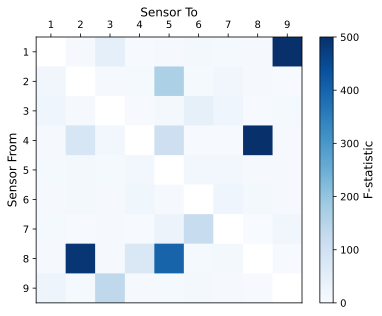

In [33]:
# create pivot table for easy plotting
pivot_df = granger_df.pivot(index='sensor_from', columns='sensor_to', values='f_statistic')
pivot_df = pivot_df.reindex(index=sensor_names, columns=sensor_names)

# create heatmap}
# plt.figure(figsize=(10, 8))
# cmap='RdYlBu_r'
cmap = 'Blues'
vmin, vmax = 0, 500
cax = plt.imshow(pivot_df.astype(float), cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
plt.xticks(np.arange(9), np.arange(1, 10))
plt.yticks(np.arange(9), np.arange(1, 10))
cbar = plt.colorbar(cax, label='F-statistic')
cbar.set_label('F-statistic', fontsize=12)
plt.xlabel('Sensor To', fontsize=12)
plt.ylabel('Sensor From', fontsize=12)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labeltop=True, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.show()